# Preliminaries

In [2]:
import collections
import datetime
import gzip
import importlib
import inspect
import ipaddress
import itertools
import json
import math
import os
import pathlib
import pickle
import random
import re
import subprocess
import sys
import time
import timeit
import warnings

import numpy as np
import pandas as pd

from sklearn import cluster as sklearn_cluster
from sklearn import metrics as sklearn_metrics
from sklearn import model_selection as sklearn_model_selection
from sklearn import neighbors as sklearn_neighbors
from sklearn import preprocessing as sklearn_preprocessing

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [41]:
plt.style.use('tableau-colorblind10')

In [3]:
ROOT_DIRPATH = '/content/drive/Shareddrives/Project - VNET/Experiments/Clustering of Network Nodes'
DATA_DIRPATH = os.path.join(ROOT_DIRPATH, '2023-01-12')

RANDOM_STATE = 42

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [5]:
def load_df(filepath, csv_sep='|'):
    if filepath.endswith('.gz'):
        with gzip.open(filepath, 'rb') as f:
            df = pd.read_csv(f, sep=csv_sep)
    elif filepath.endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif filepath.endswith('.pkl-zip'):
        df = pd.read_pickle(filepath, compression='zip')
    elif filepath.endswith('.csv'):
        df = pd.read_csv(filepath, sep=csv_sep)
    else:
        df = pd.read_pickle(filepath)

    return df


def load_module_and_obj(obj_full_name):
    module_path, _, obj_name = obj_full_name.rpartition('.')
    module = importlib.import_module(module_path)

    return module, getattr(module, obj_name)


class _IPCategories:

    def __init__(self, df_ip_categories, max_prefixlen_diff_for_subnet_expansion=5):
        self.ip_categories = df_ip_categories.drop_duplicates(ignore_index=True).copy()
        self.max_prefixlen_diff_for_subnet_expansion = max_prefixlen_diff_for_subnet_expansion

        self.ip_categories['host_or_subnet'] = 'host'
        self.ip_categories.loc[
            self.ip_categories['ip'].str.contains('/', regex=False), 'host_or_subnet'
        ] = 'subnet'

        self.ip_categories['ip_obj'] = None

        host_cond = self.ip_categories['host_or_subnet'] == 'host'
        subnet_cond = self.ip_categories['host_or_subnet'] == 'subnet'
        self.ip_categories.loc[host_cond, 'ip_obj'] = (
            self.ip_categories.loc[host_cond, 'ip'].apply(ipaddress.ip_address))
        self.ip_categories.loc[subnet_cond, 'ip_obj'] = (
            self.ip_categories.loc[subnet_cond, 'ip'].apply(ipaddress.ip_network))

        self.ip_categories['version'] = self.ip_categories['ip_obj'].apply(self._get_ip_version)

        self.ip_categories = self._expand_subnets_to_ips(self.ip_categories)

        # Cannot reuse host_cond or subnet_cond, new rows have been added by now
        ip_addresses = self.ip_categories.loc[
            self.ip_categories['host_or_subnet'] == 'host', 'ip_obj'].tolist()
        ip_networks = self.ip_categories.loc[
            self.ip_categories['host_or_subnet'] == 'subnet', 'ip_obj'].tolist()

        self.ipv4_set = set([
            ip_address for ip_address in ip_addresses
            if isinstance(ip_address, ipaddress.IPv4Address)])
        self.ipv6_set = set([
            ip_address for ip_address in ip_addresses
            if isinstance(ip_address, ipaddress.IPv6Address)])
        self.ip_set = self.ipv4_set | self.ipv6_set

        self.ipv4_networks = [
            ip_network for ip_network in ip_networks
            if isinstance(ip_network, ipaddress.IPv4Network)]
        self.ipv6_networks = [
            ip_network for ip_network in ip_networks
            if isinstance(ip_network, ipaddress.IPv6Network)]
        self.ip_networks = self.ipv4_networks + self.ipv6_networks

    @staticmethod
    def _get_ip_version(ip_obj):
        if isinstance(ip_obj, ipaddress.IPv4Address) or isinstance(ip_obj, ipaddress.IPv4Network):
            return 4
        else:
            return 6

    def _expand_subnets_to_ips(self, df_ip_categories):
        return pd.concat(
            df_ip_categories.apply(self._expand_subnets_to_ips_per_row, axis=1).tolist(),
            ignore_index=True)

    def _expand_subnets_to_ips_per_row(self, row):
        if row['version'] not in [4, 6]:
            raise ValueError('invalid IP address version, must be 4 or 6')

        should_expand = False

        if row['host_or_subnet'] == 'subnet':
            if row['version'] == 4:
                max_prefixlen = 32
            else:
                max_prefixlen = 128

            if max_prefixlen - row['ip_obj'].prefixlen <= self.max_prefixlen_diff_for_subnet_expansion:
                should_expand = True

        if should_expand:
            new_ips = [
                pd.Series([str(new_ip), row['type'], 'host', new_ip, row['version']], index=row.index)
                for new_ip in row['ip_obj']
            ]
            return pd.DataFrame(new_ips, columns=row.index.tolist())
        else:
            return row.to_frame().T


def load_ip_categories(ip_categories_filepaths):
    if isinstance(ip_categories_filepaths, str):
        ip_categories_filepaths = [ip_categories_filepaths]

    df_ip_categories = pd.concat([
        pd.read_csv(filepath) for filepath in ip_categories_filepaths
    ]).reset_index(drop=True)

    return _IPCategories(df_ip_categories)

In [6]:
def load_features_and_labels(features_filepath, labels_filepath, ip_categories, remove_unknown_ips=True):
    df_features = load_df(features_filepath)

    df_labels = load_df(labels_filepath)
    df_labels['ip_address_obj'] = df_labels['ip_address'].apply(ipaddress.ip_address)
    df_labels = df_labels[['ip_address', 'ip_address_obj', 'category']].copy()

    if remove_unknown_ips:
        df_labels = df_labels[df_labels['category'] != 'Unknown'].reset_index(drop=True)
        df_features = df_features.iloc[df_labels.index].copy()

    return df_features, df_labels

# Loading features, categories and cluster labels

In [7]:
ip_categories = load_ip_categories([
    os.path.join(ROOT_DIRPATH, 'VNET_IP_list', 'categories.csv'),
    os.path.join(ROOT_DIRPATH, 'VNET_IP_list', 'prefixes_routed_to_digitalis_ipv4.csv'),
    os.path.join(ROOT_DIRPATH, 'VNET_IP_list', 'prefixes_routed_to_digitalis_ipv6.csv'),
])

df_ip_categories = ip_categories.ip_categories

In [8]:
df_ip_categories

ip type host_or_subnet              ip_obj version
0            217.73.22.16  NET           host        217.73.22.16       4
1            81.89.53.237  NET           host        81.89.53.237       4
2          46.229.224.222   SH           host      46.229.224.222       4
3           109.74.146.55   SH           host       109.74.146.55       4
4             81.89.48.46   SH           host         81.89.48.46       4
...                   ...  ...            ...                 ...     ...
23405      2a01:390:1::a7   SH           host      2a01:390:1::a7       6
23406    2a01:390:1::cafe   SH           host    2a01:390:1::cafe       6
23407    2a01:390:1::caff   SH           host    2a01:390:1::caff       6
23408  2a01:390:1:7::cafe   SH           host  2a01:390:1:7::cafe       6
23409  2a01:390:1:7::caff   SH           host  2a01:390:1:7::caff       6

[23410 rows x 5 columns]

In [9]:
df_features, df_labels = load_features_and_labels(
    os.path.join(DATA_DIRPATH, 'features', 'scenario_1.parquet'),
    os.path.join(DATA_DIRPATH, 'features', 'scenario_1_labels.parquet'),
    ip_categories)

df_features_scenario_6, df_labels_scenario_6 = load_features_and_labels(
    os.path.join(DATA_DIRPATH, 'features', 'scenario_6.parquet'),
    os.path.join(DATA_DIRPATH, 'features', 'scenario_6_labels.parquet'),
    ip_categories)

In [10]:
with pd.option_context('display.max_columns', None):
    display(df_features)

num_flows_per_ip  \
IP_SRC_ADDR                                                 
46.229.238.68                                    27879058   
93.184.67.96                                     15464059   
45.89.54.100                                      9029974   
86.110.230.132                                     505343   
185.66.200.197                                    1567066   
...                                                   ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                 1   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                  1   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                 1   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                  1   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                 1   

                                         src_port_category_entropy  \
IP_SRC_ADDR                                                          
46.229.238.68                                             0.133045   
93.184.67.96                                              0.583302   
45.89.54.100                                              0.986182   
86.110.230.132                                            0.689093   
185.66.200.197                                            0.573584   
...                                                            ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                   0.000000   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                    0.000000   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                   0.000000   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                    0.000000   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                   0.000000   

                                         dst_port_category_entropy  \
IP_SRC_ADDR                                                          
46.229.238.68                                             0.735363   
93.184.67.96                                              1.124292   
45.89.54.100                                              0.854856   
86.110.230.132                                            1.309980   
185.66.200.197                                            0.943693   
...                                                            ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                   0.000000   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                    0.000000   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                   0.000000   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                    0.000000   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                   0.000000   

                                         num_src_ports_noport  \
IP_SRC_ADDR                                                     
46.229.238.68                                           68641   
93.184.67.96                                             3307   
45.89.54.100                                           883262   
86.110.230.132                                          30365   
185.66.200.197                                          83150   
...                                                       ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                     1   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                      1   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                     1   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                      1   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                     1   

                                         num_dst_ports_noport  \
IP_SRC_ADDR                                                     
46.229.238.68                                           68646   
93.184.67.96                                             3084   
45.89.54.100                                           883262   
86.110.230.132                                          30365   
185.66.200.197                                          83150   
...                                                       ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                    

In [11]:
df_labels

ip_address  \
0                                 46.229.238.68   
1                                  93.184.67.96   
2                                  45.89.54.100   
3                                86.110.230.132   
4                                185.66.200.197   
...                                         ...   
385291  2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12   
385292   2a11:7e04:814:a993:a7b5:c501:d7f8:1a86   
385293  2a11:7e04:5114:45e7:5322:d724:4a26:3697   
385294   2a11:7e04:3351:f75a:58a6:e799:6375:e7f   
385295  2a11:7e04:8239:8ec7:5985:1fa3:a087:f803   

                                 ip_address_obj category  
0                                 46.229.238.68       SH  
1                                  93.184.67.96      NET  
2                                  45.89.54.100       SH  
3                                86.110.230.132       SH  
4                                185.66.200.197       SH  
...                                         ...      ...  
385291  2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12       SH  
385292   2a11:7e04:814:a993:a7b5:c501:d7f8:1a86       SH  
385293  2a11:7e04:5114:45e7:5322:d724:4a26:3697       SH  
385294   2a11:7e04:3351:f75a:58a6:e799:6375:e7f       SH  
385295  2a11:7e04:8239:8ec7:5985:1fa3:a087:f803       SH  

[385296 rows x 3 columns]

In [12]:
df_features['category'] = df_labels['category'].to_numpy()
df_features_scenario_6['category'] = df_labels_scenario_6['category'].to_numpy()

In [13]:
df_ip_categories['type'].value_counts()

SH     20481
NET     2929
Name: type, dtype: int64

In [14]:
print(df_features['category'].value_counts())
print()
print(df_features_scenario_6['category'].value_counts())

SH     383940
NET      1356
Name: category, dtype: int64

SH     15601
NET     1317
Name: category, dtype: int64


# Filtering IPs

A vast majority of nodes has 1 flow only, rendering them unsuitable for clustering (not enough data to describe the node). Most of these appear to belong to the same IPv6 subnet.

(Could this indicate an attack?)

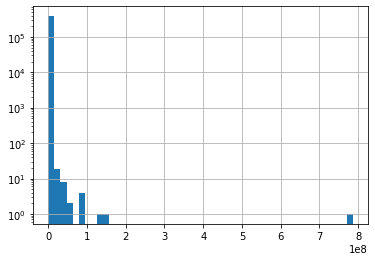

In [15]:
df_features['num_flows_per_ip'].hist(bins=50, log=True)

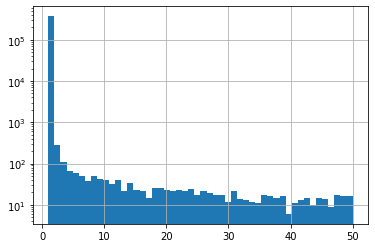

In [16]:
df_features[df_features['num_flows_per_ip'] <= 50]['num_flows_per_ip'].hist(bins=50, log=True)

In [17]:
print(len(df_features[df_features['num_flows_per_ip'] == 1]))
print(len(df_features[df_features['num_flows_per_ip'] == 2]))
print(len(df_features[df_features['num_flows_per_ip'] == 3]))
print(len(df_features[df_features['num_flows_per_ip'] == 4]))
print(len(df_features[df_features['num_flows_per_ip'] == 5]))

373382
275
108
66
59


In [18]:
df_features[df_features['num_flows_per_ip'] == 1]

num_flows_per_ip  \
IP_SRC_ADDR                                                 
2a11:7e04:bf7:89ab:c9dc:fb2b:19ee:a14a                  1   
2a11:7e04:df5b:f8db:dbac:d77d:cdbd:89f5                 1   
2a11:7e04:4821:d4d2:4b2d:5a2c:20e3:2353                 1   
2a11:7e04:3346:6449:a5ca:89c9:2d28:7314                 1   
2a11:7e04:2904:ebce:1684:2fa8:4462:d704                 1   
...                                                   ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                 1   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                  1   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                 1   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                  1   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                 1   

                                         src_port_category_entropy  \
IP_SRC_ADDR                                                          
2a11:7e04:bf7:89ab:c9dc:fb2b:19ee:a14a                         0.0   
2a11:7e04:df5b:f8db:dbac:d77d:cdbd:89f5                        0.0   
2a11:7e04:4821:d4d2:4b2d:5a2c:20e3:2353                        0.0   
2a11:7e04:3346:6449:a5ca:89c9:2d28:7314                        0.0   
2a11:7e04:2904:ebce:1684:2fa8:4462:d704                        0.0   
...                                                            ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                        0.0   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                         0.0   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                        0.0   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                         0.0   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                        0.0   

                                         dst_port_category_entropy  \
IP_SRC_ADDR                                                          
2a11:7e04:bf7:89ab:c9dc:fb2b:19ee:a14a                         0.0   
2a11:7e04:df5b:f8db:dbac:d77d:cdbd:89f5                        0.0   
2a11:7e04:4821:d4d2:4b2d:5a2c:20e3:2353                        0.0   
2a11:7e04:3346:6449:a5ca:89c9:2d28:7314                        0.0   
2a11:7e04:2904:ebce:1684:2fa8:4462:d704                        0.0   
...                                                            ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                        0.0   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                         0.0   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                        0.0   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                         0.0   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                        0.0   

                                         num_src_ports_noport  \
IP_SRC_ADDR                                                     
2a11:7e04:bf7:89ab:c9dc:fb2b:19ee:a14a                      1   
2a11:7e04:df5b:f8db:dbac:d77d:cdbd:89f5                     1   
2a11:7e04:4821:d4d2:4b2d:5a2c:20e3:2353                     1   
2a11:7e04:3346:6449:a5ca:89c9:2d28:7314                     1   
2a11:7e04:2904:ebce:1684:2fa8:4462:d704                     1   
...                                                       ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                     1   
2a11:7e04:814:a993:a7b5:c501:d7f8:1a86                      1   
2a11:7e04:5114:45e7:5322:d724:4a26:3697                     1   
2a11:7e04:3351:f75a:58a6:e799:6375:e7f                      1   
2a11:7e04:8239:8ec7:5985:1fa3:a087:f803                     1   

                                         num_dst_ports_noport  \
IP_SRC_ADDR                                                     
2a11:7e04:bf7:89ab:c9dc:fb2b:19ee:a14a                      1   
2a11:7e04:df5b:f8db:dbac:d77d:cdbd:89f5                     1   
2a11:7e04:4821:d4d2:4b2d:5a2c:20e3:2353                     1   
2a11:7e04:3346:6449:a5ca:89c9:2d28:7314                     1   
2a11:7e04:2904:ebce:1684:2fa8:4462:d704                     1   
...                                                       ...   
2a11:7e04:2c6c:943c:4990:9b7c:a3b0:8a12                    

Almost all of these addresses are IPv6 addresses and non-TCP/UDP.

In [19]:
def get_ip_version(ip_str):
    ip_addr = ipaddress.ip_address(ip_str)

    if isinstance(ip_addr, ipaddress.IPv4Address):
        return 'IPv4'
    else:
        return 'IPv6'

print(df_features[df_features['num_flows_per_ip'] == 1].index.to_series().apply(get_ip_version).value_counts())

IPv6    373118
IPv4       264
Name: IP_SRC_ADDR, dtype: int64


We filter nodes with 1 flow to focus on nodes with more data to work with.

In [20]:
df_features_filtered = df_features[df_features['num_flows_per_ip'] > 1].copy()
df_labels_filtered = df_labels[df_labels['ip_address'].isin(df_features_filtered.index)].reset_index(drop=True)

df_features_scenario_6_filtered = df_features_scenario_6[df_features_scenario_6['num_flows_per_ip'] > 1].copy()
df_labels_scenario_6_filtered = df_labels_scenario_6[df_labels_scenario_6['ip_address'].isin(df_features_scenario_6_filtered.index)].reset_index(drop=True)

In [21]:
df_features_filtered

num_flows_per_ip  \
IP_SRC_ADDR                                             
46.229.238.68                                27879058   
93.184.67.96                                 15464059   
45.89.54.100                                  9029974   
86.110.230.132                                 505343   
185.66.200.197                                1567066   
...                                               ...   
2a01:390:12:4:8a30:51df:2c22:b41a                   2   
93.184.72.27                                        6   
2a01:390:12:13:9add:d27:2acc:8bd5                   2   
2a01:390:dc4f:0:ab1a:c1e4:35af:c47b                 2   
2a01:390:12:3:a049:1c24:88dd:c8c1                   2   

                                     src_port_category_entropy  \
IP_SRC_ADDR                                                      
46.229.238.68                                         0.133045   
93.184.67.96                                          0.583302   
45.89.54.100                                          0.986182   
86.110.230.132                                        0.689093   
185.66.200.197                                        0.573584   
...                                                        ...   
2a01:390:12:4:8a30:51df:2c22:b41a                     0.000000   
93.184.72.27                                          0.000000   
2a01:390:12:13:9add:d27:2acc:8bd5                     0.000000   
2a01:390:dc4f:0:ab1a:c1e4:35af:c47b                   0.000000   
2a01:390:12:3:a049:1c24:88dd:c8c1                     0.000000   

                                     dst_port_category_entropy  \
IP_SRC_ADDR                                                      
46.229.238.68                                         0.735363   
93.184.67.96                                          1.124292   
45.89.54.100                                          0.854856   
86.110.230.132                                        1.309980   
185.66.200.197                                        0.943693   
...                                                        ...   
2a01:390:12:4:8a30:51df:2c22:b41a                     0.000000   
93.184.72.27                                          0.000000   
2a01:390:12:13:9add:d27:2acc:8bd5                     0.000000   
2a01:390:dc4f:0:ab1a:c1e4:35af:c47b                   0.000000   
2a01:390:12:3:a049:1c24:88dd:c8c1                     0.000000   

                                     num_src_ports_noport  \
IP_SRC_ADDR                                                 
46.229.238.68                                       68641   
93.184.67.96                                         3307   
45.89.54.100                                       883262   
86.110.230.132                                      30365   
185.66.200.197                                      83150   
...                                                   ...   
2a01:390:12:4:8a30:51df:2c22:b41a                       0   
93.184.72.27                                            0   
2a01:390:12:13:9add:d27:2acc:8bd5                       0   
2a01:390:dc4f:0:ab1a:c1e4:35af:c47b                     0   
2a01:390:12:3:a049:1c24:88dd:c8c1                       0   

                                     num_dst_ports_noport  \
IP_SRC_ADDR                                                 
46.229.238.68                                       68646   
93.184.67.96                                         3084   
45.89.54.100                                       883262   
86.110.230.132                                      30365   
185.66.200.197                                      83150   
...                                                   ...   
2a01:390:12:4:8a30:51df:2c22:b41a                       0   
93.184.72.27                                            0   
2a01:390:12:13:9add:d27:2acc:8bd5                       0   
2a01:390:dc4f:0:ab1a:c1e4:35af:c47b                     0   
2a01:390:12:3:a049:1c24:88dd:c8c1                  

In [22]:
print(df_features_filtered['category'].value_counts())
print()
print(df_features_scenario_6_filtered['category'].value_counts())

SH     10567
NET     1347
Name: category, dtype: int64

SH     9298
NET    1285
Name: category, dtype: int64


# in_out_bytes_ratio feature - counts per category

In [23]:
print('in_out_bytes_ratio feature')
print()
print('Scenario 1')
print('Number of nodes with ratio < 0.8')

print(
    'SH:',
    len(df_features_filtered[
        (df_features_filtered['in_out_bytes_ratio'] < 0.8)
        & (df_features_filtered['category'] == 'SH')
    ]),
)
print(
    'NET:',
    len(df_features_filtered[
        (df_features_filtered['in_out_bytes_ratio'] < 0.8)
        & (df_features_filtered['category'] == 'NET')
    ]),
)

print('Number of nodes with ratio > 1.2')

print(
    'SH:',
    len(df_features_filtered[
        (df_features_filtered['in_out_bytes_ratio'] > 1.2)
        & (df_features_filtered['category'] == 'SH')
    ]),
)
print(
    'NET:',
    len(df_features_filtered[
        (df_features_filtered['in_out_bytes_ratio'] > 1.2)
        & (df_features_filtered['category'] == 'NET')
    ]),
)

in_out_bytes_ratio feature

Scenario 1
Number of nodes with ratio < 0.8
SH: 6285
NET: 128
Number of nodes with ratio > 1.2
SH: 2689
NET: 1102


In [24]:
print('in_out_bytes_ratio feature')
print()
print('Scenario 6')
print('Number of nodes with ratio < 0.8')

print(
    'SH:',
    len(df_features_scenario_6_filtered[
        (df_features_scenario_6_filtered['in_out_bytes_ratio'] < 0.8)
        & (df_features_scenario_6_filtered['category'] == 'SH')
    ]),
)
print(
    'NET:',
    len(df_features_scenario_6_filtered[
        (df_features_scenario_6_filtered['in_out_bytes_ratio'] < 0.8)
        & (df_features_scenario_6_filtered['category'] == 'NET')
    ]),
)

print('Number of nodes with ratio > 1.2')

print(
    'SH:',
    len(df_features_scenario_6_filtered[
        (df_features_scenario_6_filtered['in_out_bytes_ratio'] > 1.2)
        & (df_features_scenario_6_filtered['category'] == 'SH')
    ]),
)
print(
    'NET:',
    len(df_features_scenario_6_filtered[
        (df_features_scenario_6_filtered['in_out_bytes_ratio'] > 1.2)
        & (df_features_scenario_6_filtered['category'] == 'NET')
    ]),
)

in_out_bytes_ratio feature

Scenario 6
Number of nodes with ratio < 0.8
SH: 7092
NET: 250
Number of nodes with ratio > 1.2
SH: 1905
NET: 1021


# Adding cluster labels

In [25]:
with open(os.path.join(DATA_DIRPATH, 'results', 'k_means_scenario_1_good_results_all_features_ideal_k.pkl'), 'rb') as f:
    good_results_all_features_ideal_k = pickle.load(f)

with open(os.path.join(DATA_DIRPATH, 'results', 'k_means_scenario_1_good_results_no_bytes_based_features_ideal_k.pkl'), 'rb') as f:
    good_results_no_bytes_based_features_ideal_k = pickle.load(f)

In [26]:
df_features_filtered['cluster_label_all_features'] = good_results_all_features_ideal_k['cluster_labels']
df_features_filtered['cluster_label_no_bytes_based_features'] = good_results_no_bytes_based_features_ideal_k['cluster_labels']

# Distribution of feature values

## Scenario 1

In [27]:
columns_to_plot = [col for col in df_features_filtered.columns
    if (not col.startswith('num_src_ports')
        and not col.startswith('num_dst_ports')
        and not col.startswith('cluster_label')
        and col not in ['num_flows_per_ip', 'category'])
]

### Unscaled

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae01012130>,
      dtype=object)

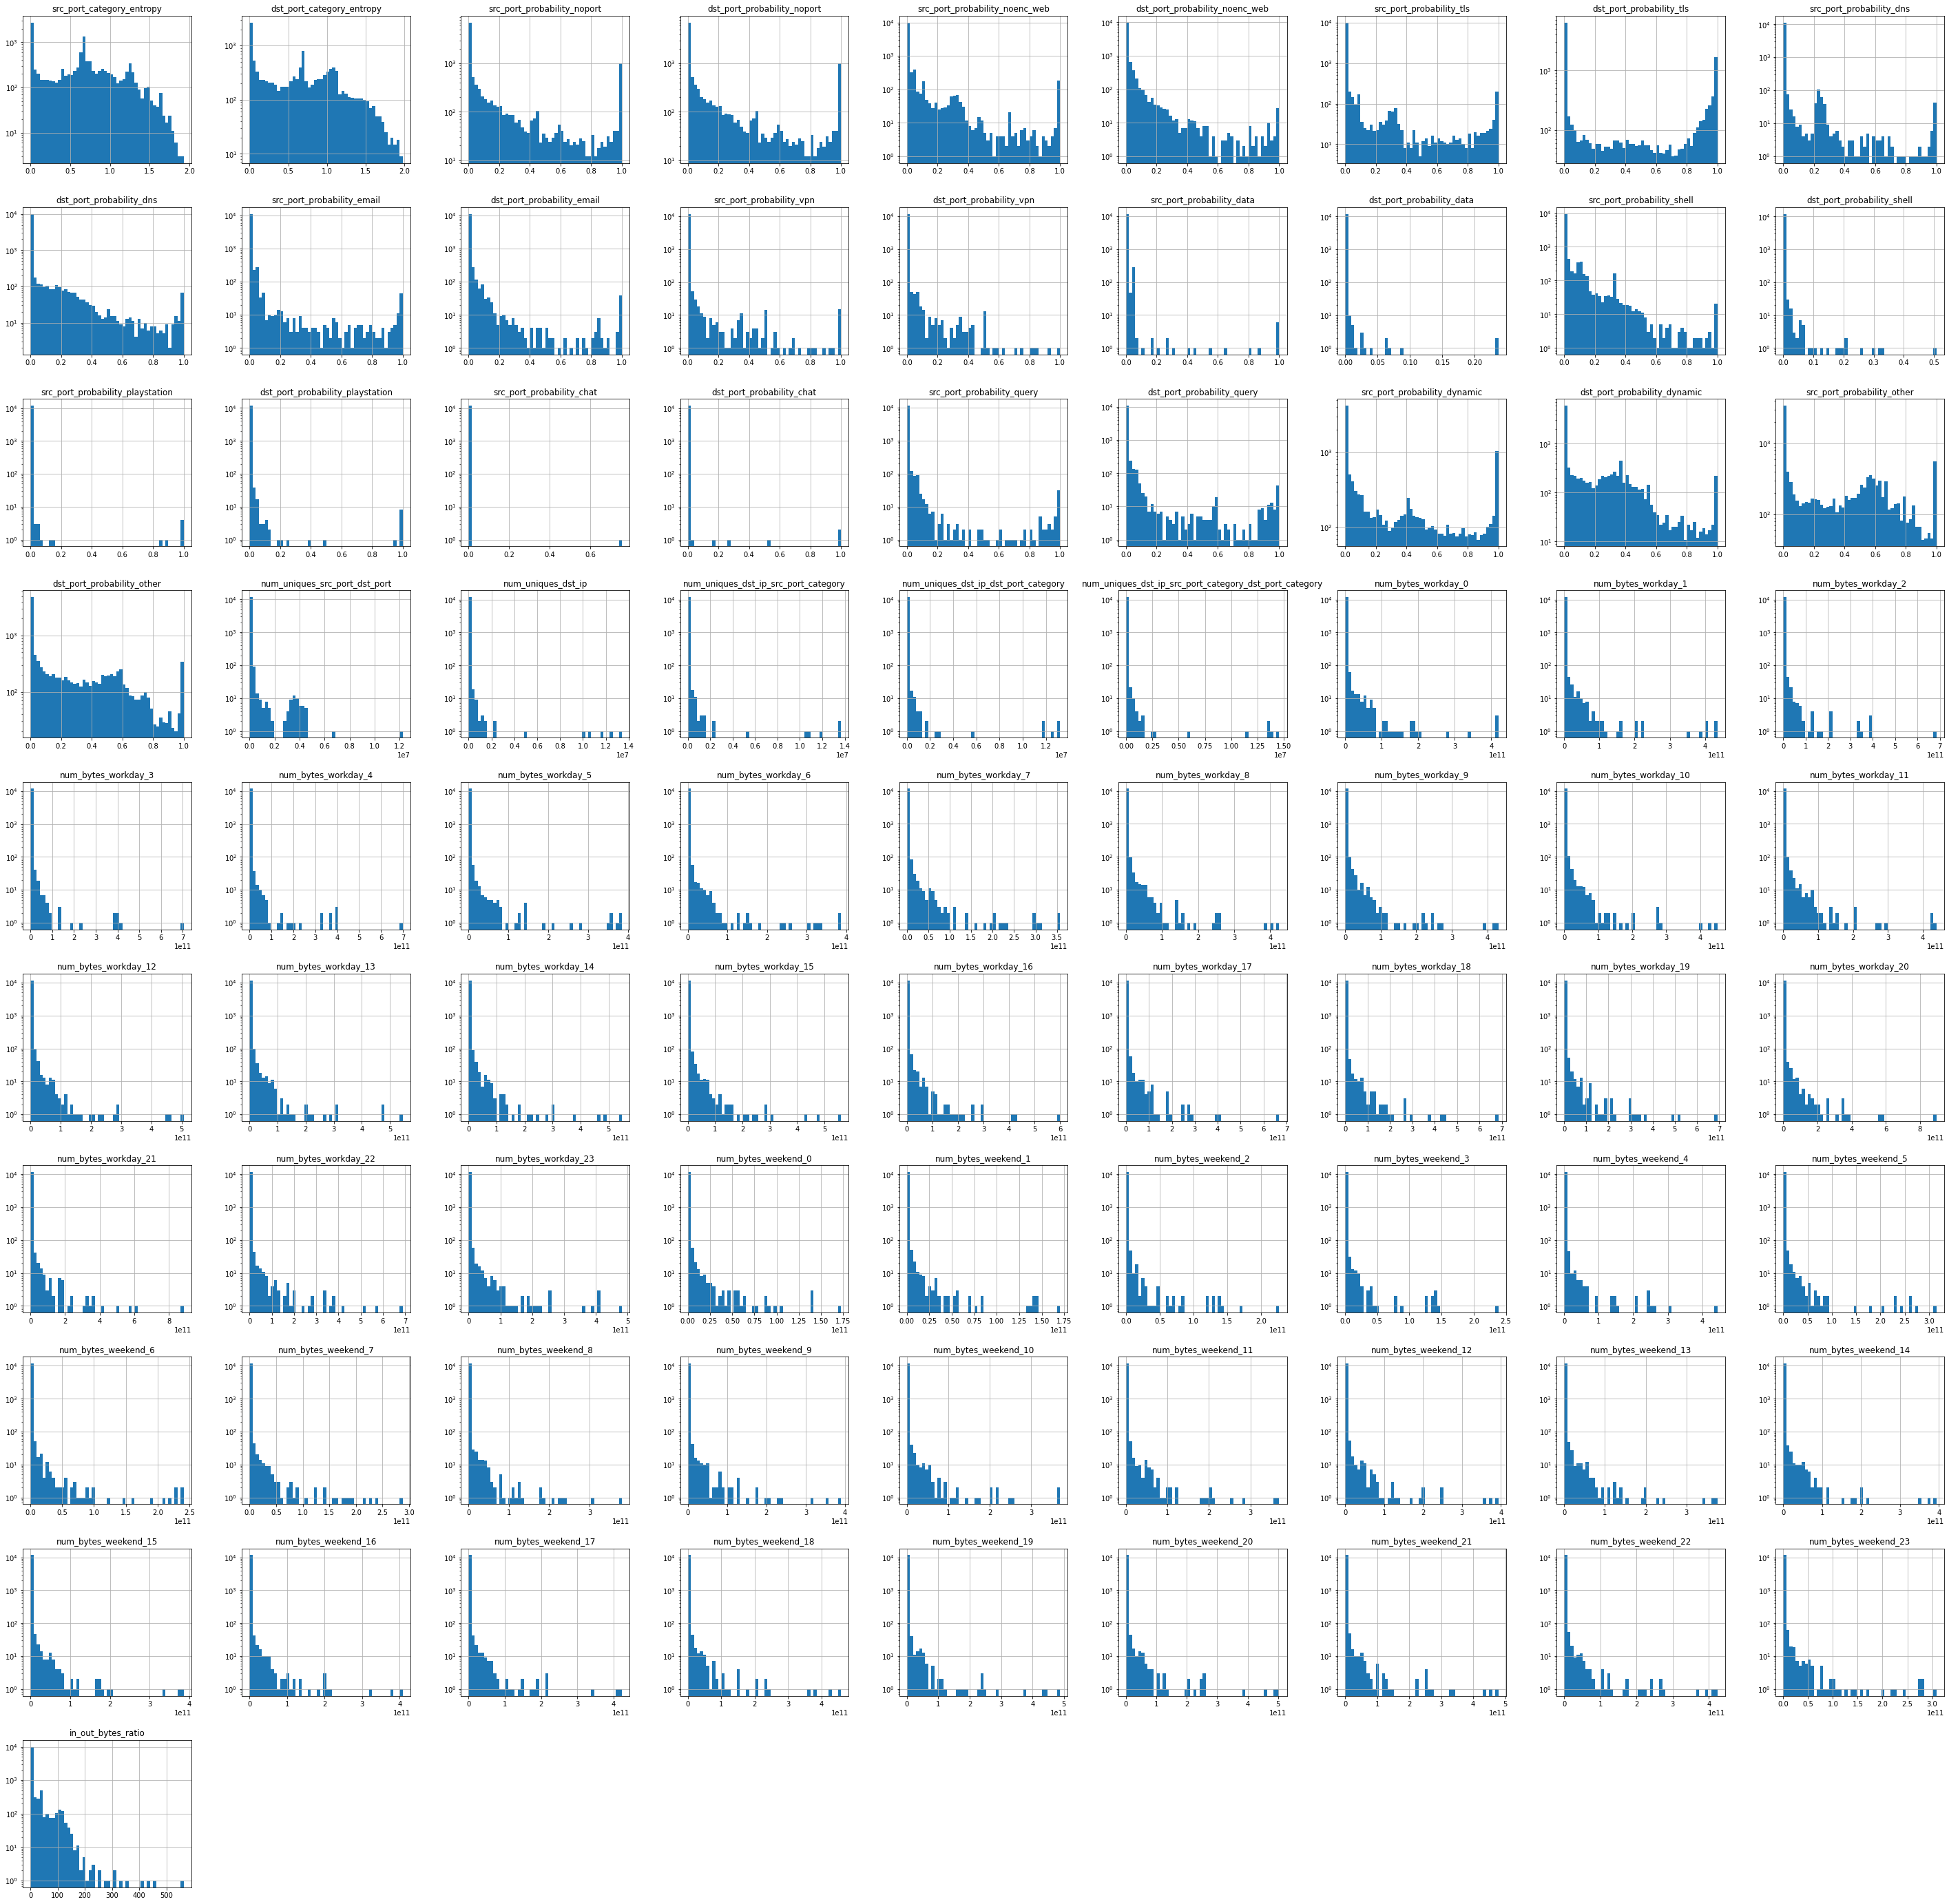

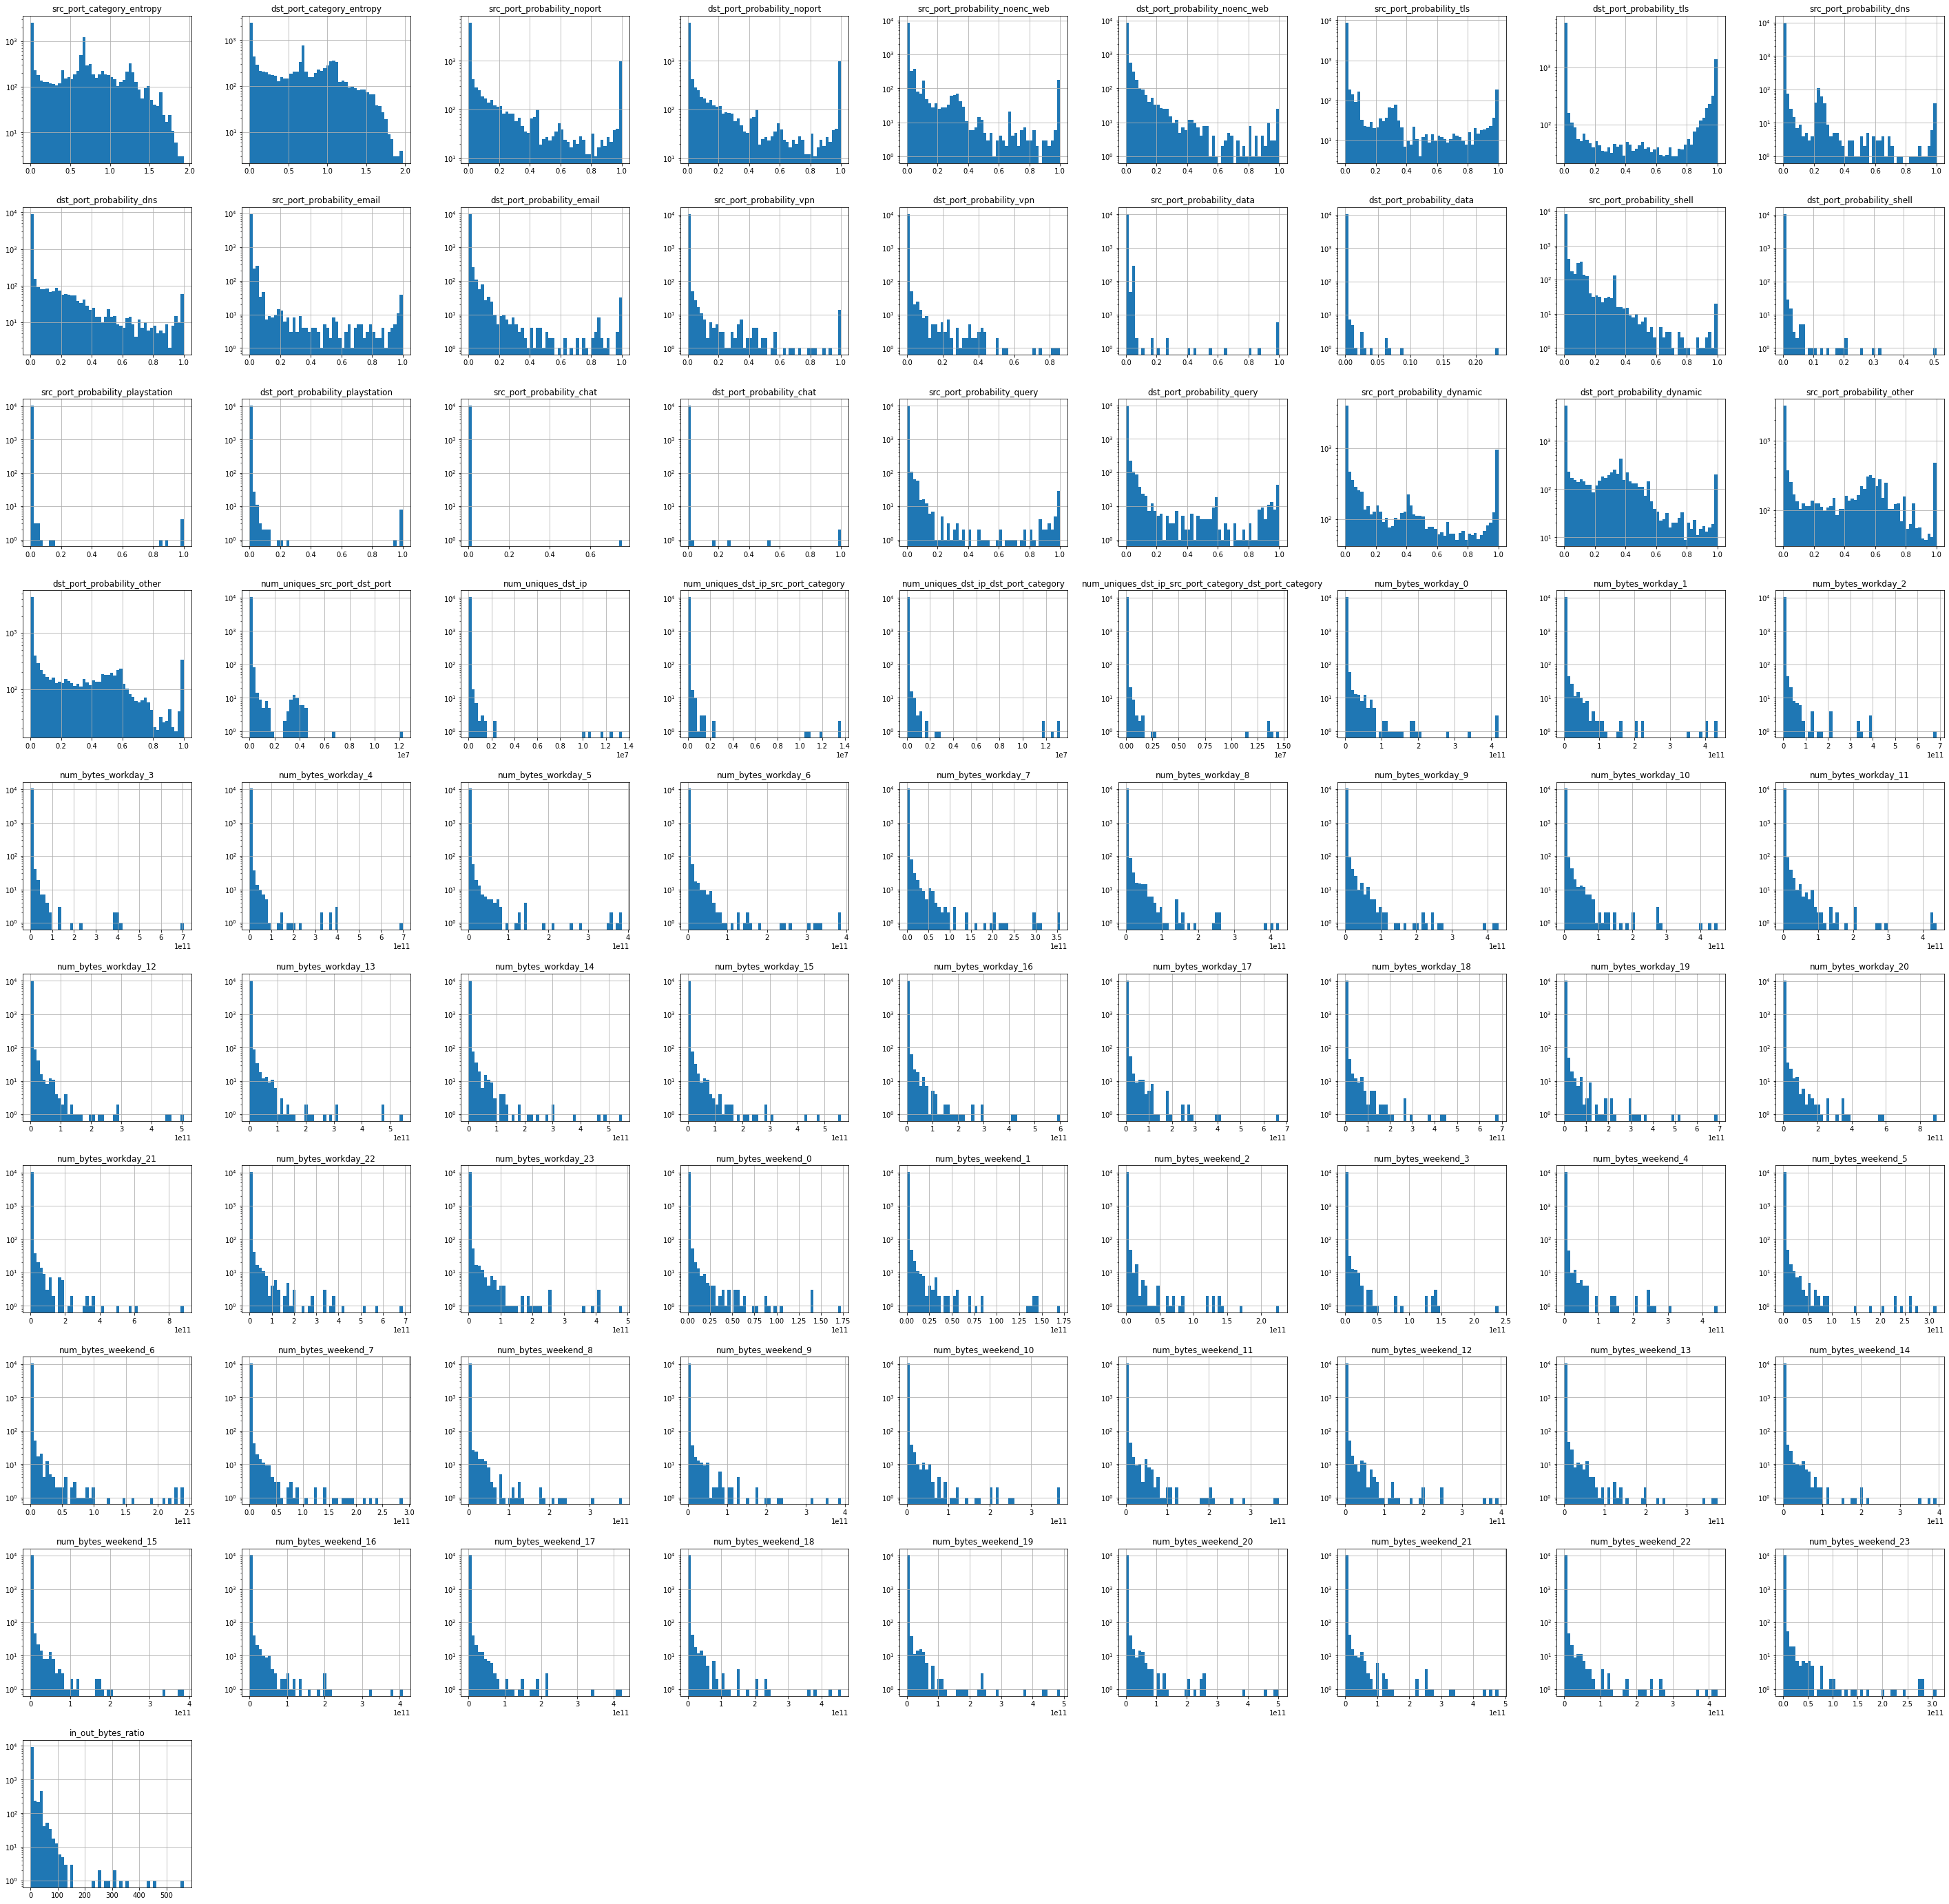

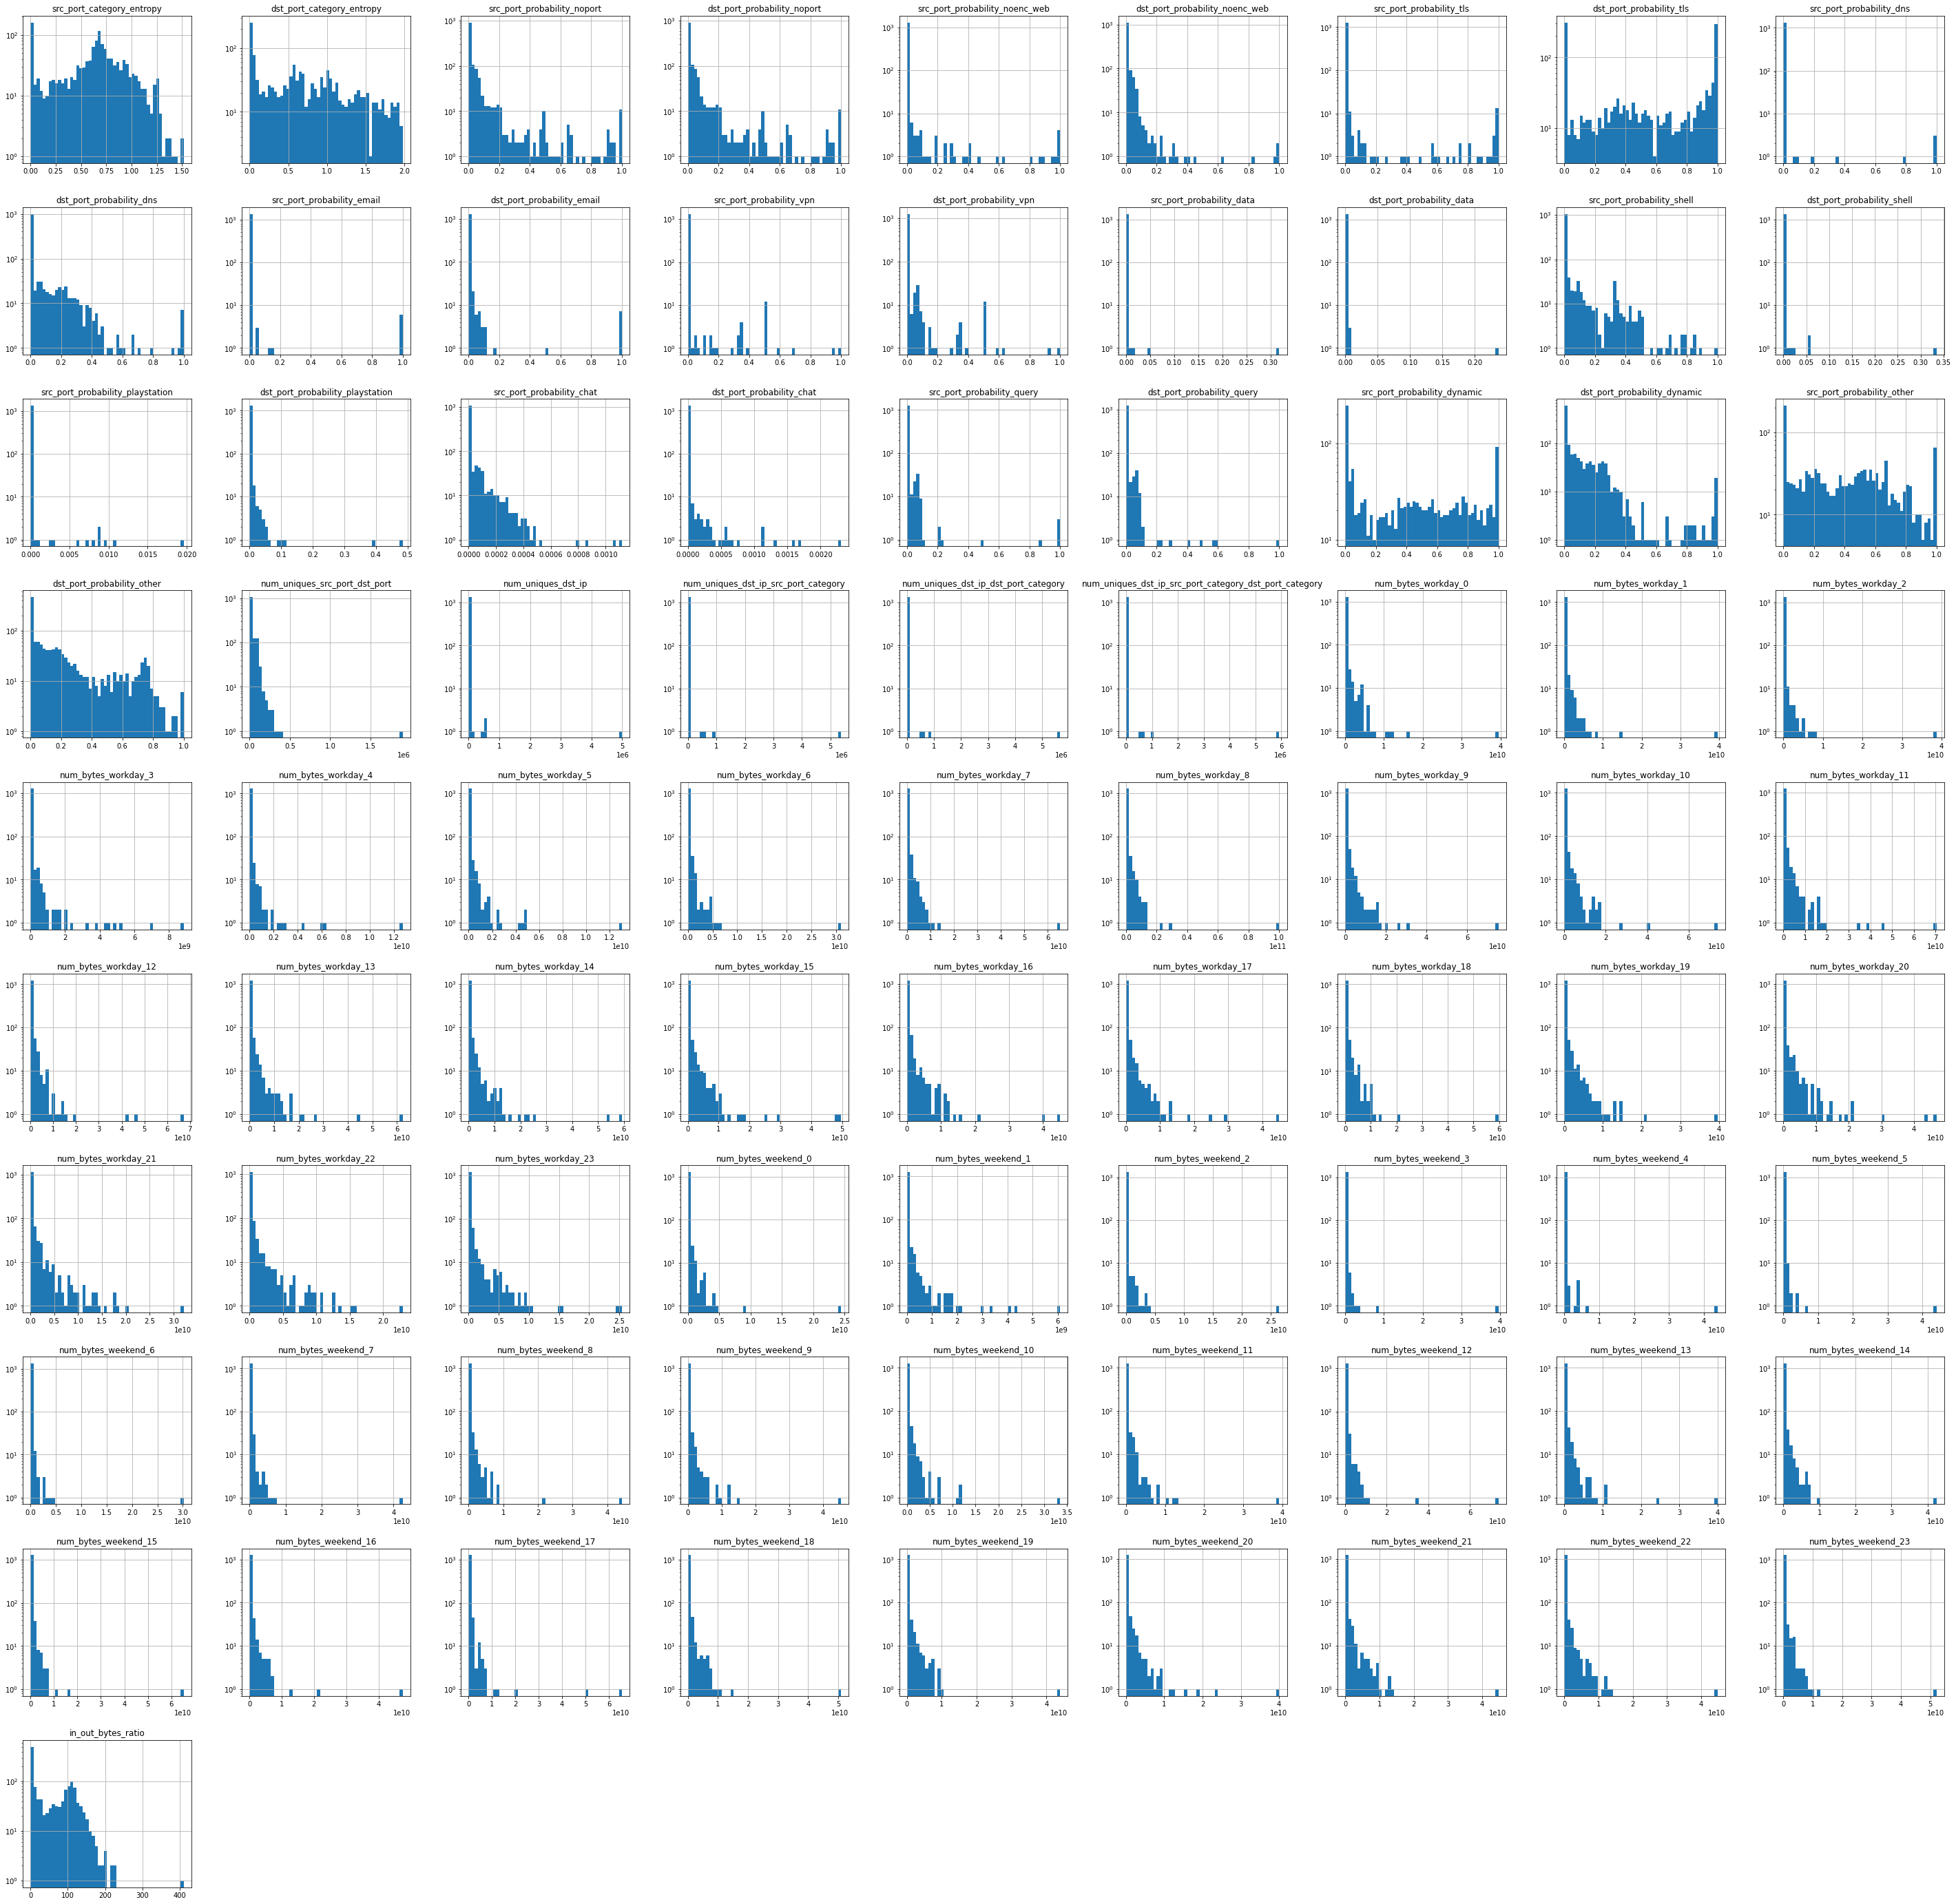

In [35]:
df_features_filtered[columns_to_plot].hist(bins=50, figsize=(50, 50), log=True)
df_features_filtered[df_features_filtered['category'] == 'SH'][columns_to_plot].hist(bins=50, figsize=(50, 50), log=True)
df_features_filtered[df_features_filtered['category'] == 'NET'][columns_to_plot].hist(bins=50, figsize=(50, 50), log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadf6ed5b50>,
      dtype=object)

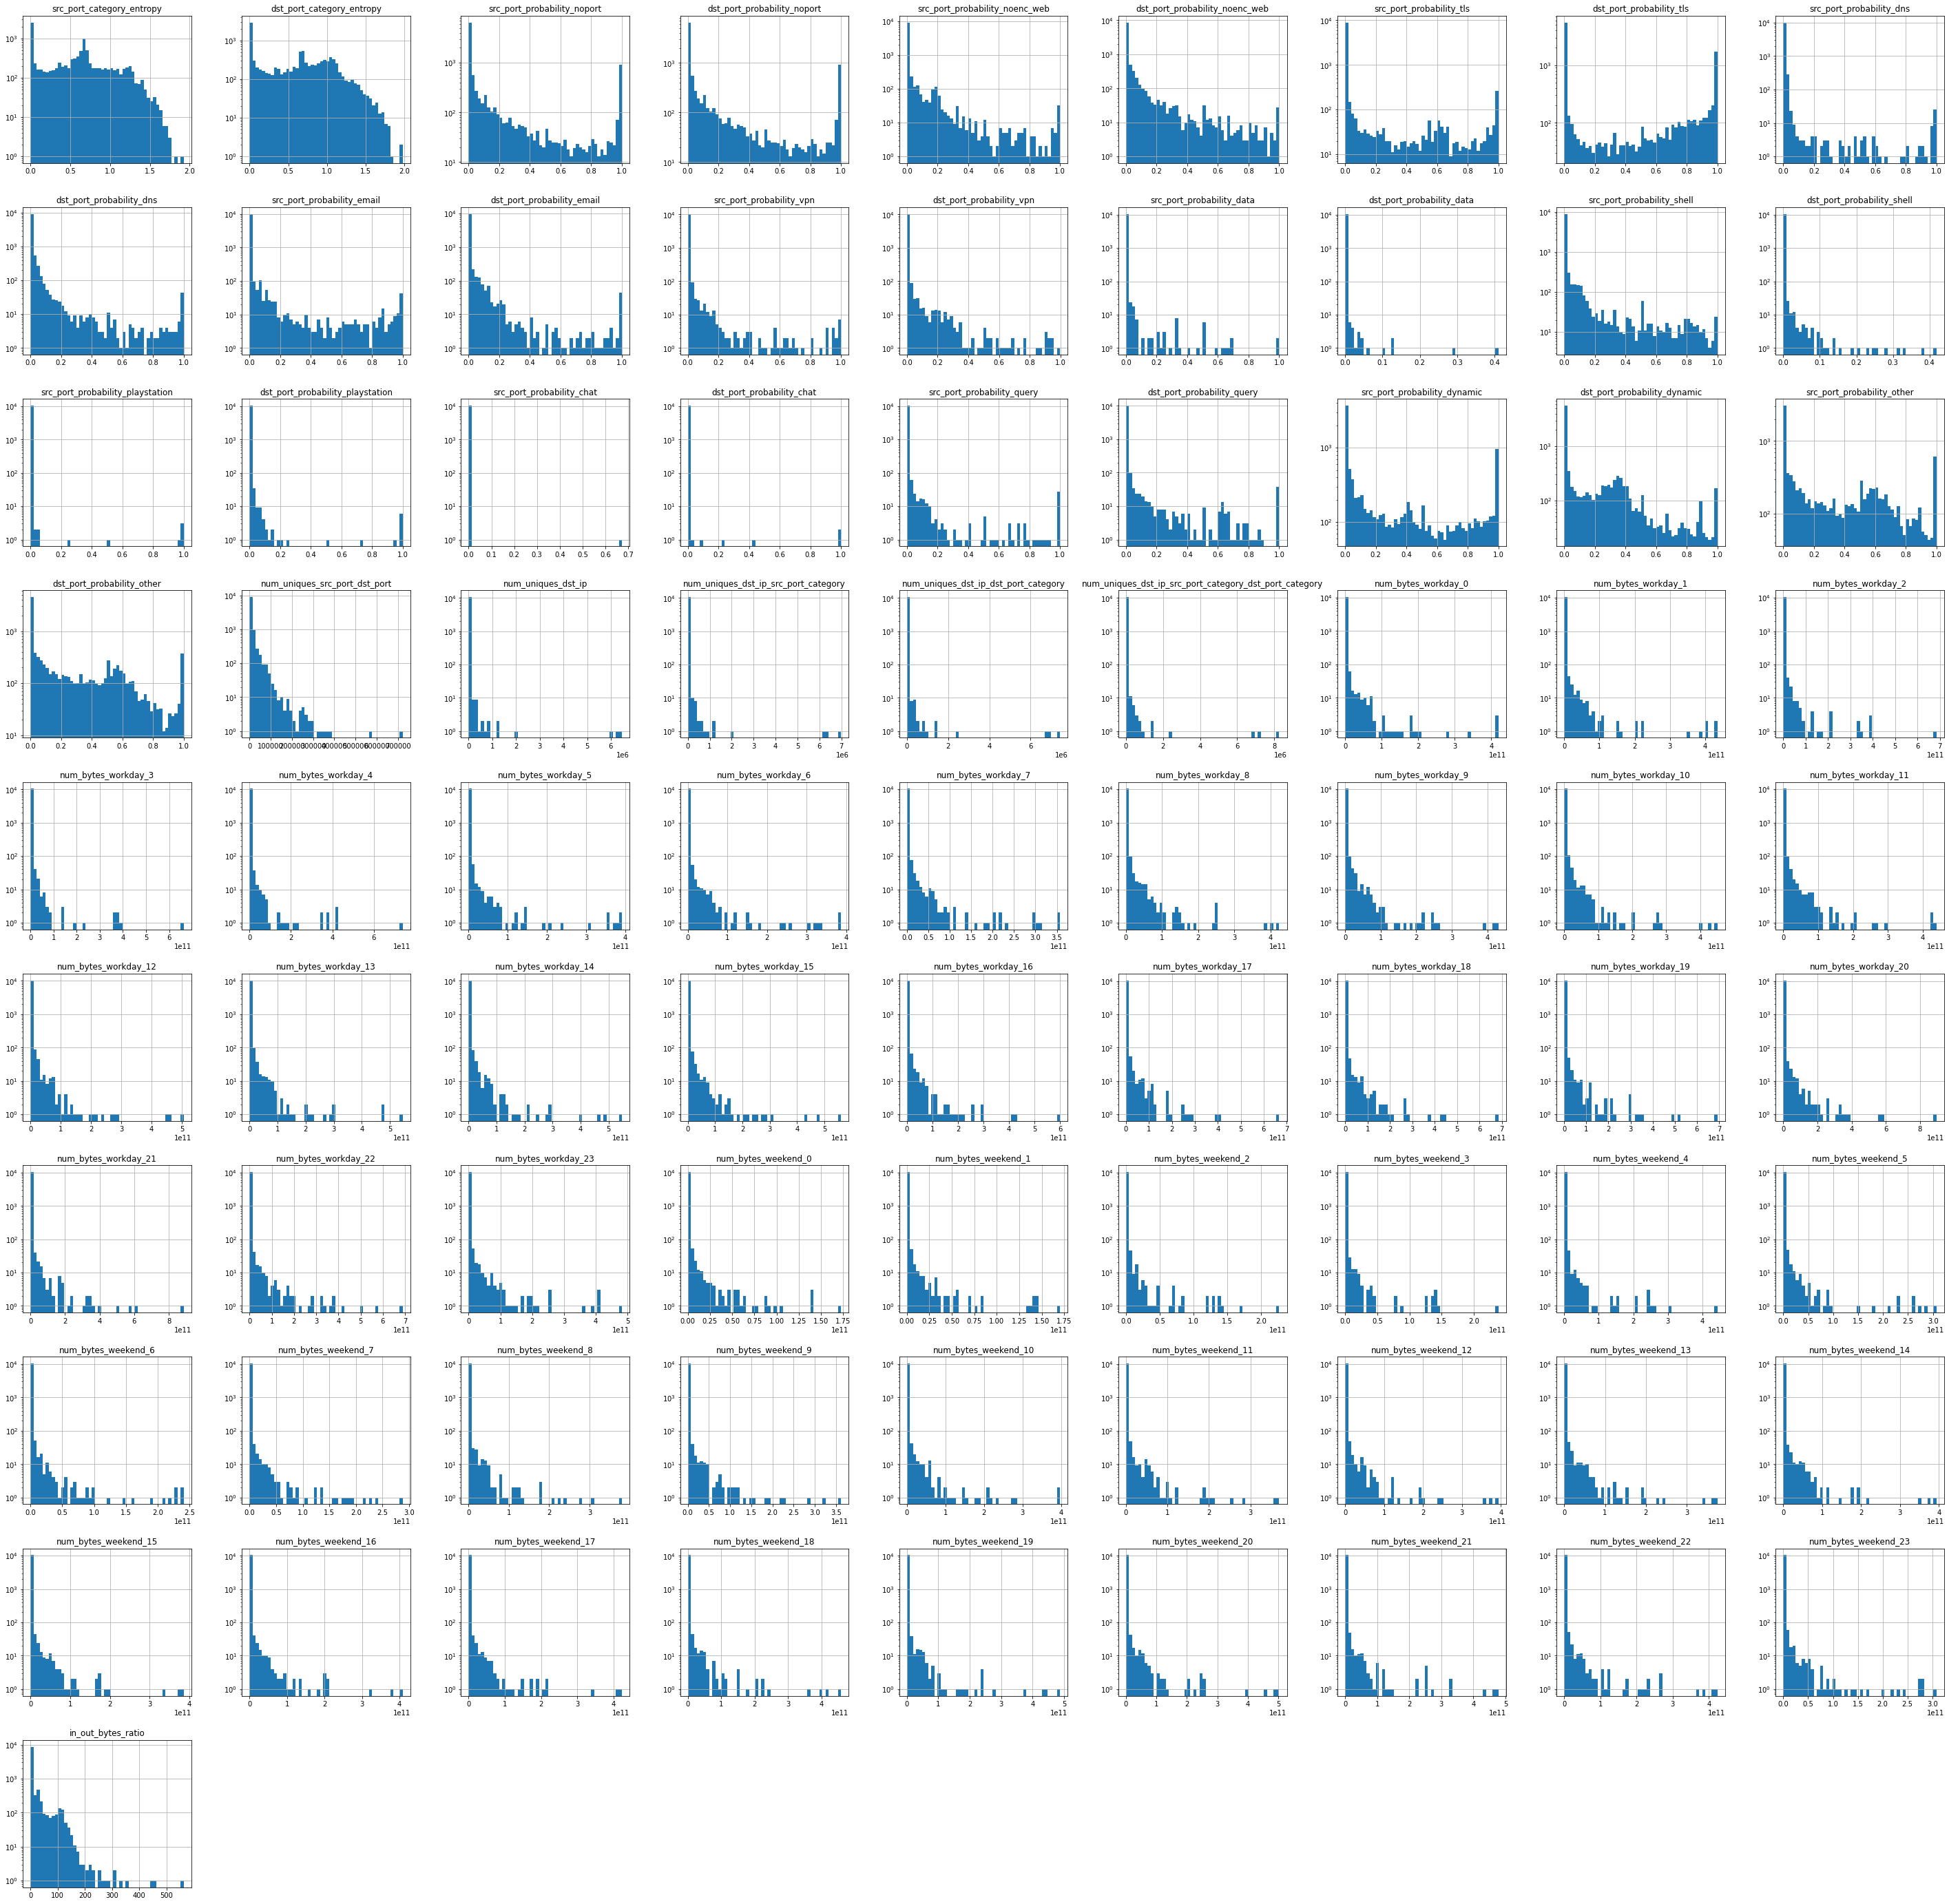

In [36]:
df_features_scenario_6_filtered[columns_to_plot].hist(bins=50, figsize=(50, 50), log=True)

Checking if there are nodes communicating extremely sporadically:

In [37]:
bytes_cols = [col for col in df_features.columns if col.startswith('num_bytes_')]
num_ports_cols = [col for col in df_features.columns if col.startswith('num_src_ports_') or col.startswith('num_dst_ports_')]

print()
print('Scenario 1:')
total_bytes = df_features_filtered[bytes_cols].sum(axis=1)
total_num_ports = df_features_filtered[num_ports_cols].sum(axis=1)
print((total_bytes < 100).sum() / len(df_features_filtered))
print((total_bytes < 500).sum() / len(df_features_filtered))
print((total_bytes < 1000).sum() / len(df_features_filtered))
print((total_bytes < 10000).sum() / len(df_features_filtered))
print()
print((total_num_ports < 5).sum() / len(df_features_filtered))


print()
print('Scenario 6:')
total_bytes = df_features_scenario_6_filtered[bytes_cols].sum(axis=1)
total_num_ports = df_features_scenario_6_filtered[num_ports_cols].sum(axis=1)
print((total_bytes < 100).sum() / len(df_features_scenario_6_filtered))
print((total_bytes < 500).sum() / len(df_features_scenario_6_filtered))
print((total_bytes < 1000).sum() / len(df_features_scenario_6_filtered))
print((total_bytes < 10000).sum() / len(df_features_scenario_6_filtered))
print()
print((total_num_ports < 5).sum() / len(df_features_scenario_6_filtered))


Scenario 1:
0.0014268927312405574
0.028873594090985395
0.039617257008561356
0.10491858317945274

0.023082088299479605

Scenario 6:
0.0
0.0
0.0
0.03316639894169895

0.03014268165926486


Looks like a majority of nodes expose a small set of ports:

In [38]:
print('Scenario 1:')
print(len(df_features_filtered[df_features_filtered['src_port_probability_tls'] == 0]) / len(df_features_filtered))
print(len(df_features_filtered[df_features_filtered['src_port_probability_email'] == 0]) / len(df_features_filtered))
print(len(df_features_filtered[df_features_filtered['src_port_probability_query'] == 0]) / len(df_features_filtered))
print(len(df_features_filtered[df_features_filtered['src_port_probability_data'] == 0]) / len(df_features_filtered))

sh_cond = df_features_filtered['category'] == 'SH'
print()
print(len(df_features_filtered[(df_features_filtered['src_port_probability_tls'] == 0) & sh_cond]) / len(df_features_filtered))
print(len(df_features_filtered[(df_features_filtered['src_port_probability_email'] == 0) & sh_cond]) / len(df_features_filtered))
print(len(df_features_filtered[(df_features_filtered['src_port_probability_query'] == 0) & sh_cond]) / len(df_features_filtered))
print(len(df_features_filtered[(df_features_filtered['src_port_probability_data'] == 0) & sh_cond]) / len(df_features_filtered))

Scenario 1:
0.6546080241732416
0.7045492697666611
0.6883498405237536
0.7347658217223435

0.5673157629679368
0.6193553802249454
0.6104582843713279
0.6489004532482794


Scenario 1:
0.12044653349001175
0.2882323317105926
0.344132952828605
0.3776229645794863


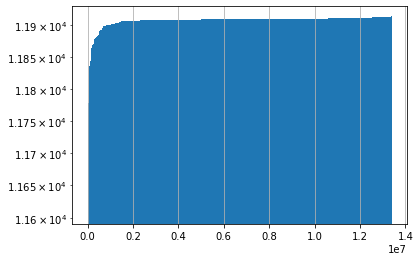

In [39]:
print('Scenario 1:')
df_features_filtered['num_uniques_dst_ip'].hist(bins=500, cumulative=True, log=True)

print(len(df_features_filtered[df_features_filtered['num_uniques_dst_ip'] <= 1]) / len(df_features_filtered))
print(len(df_features_filtered[df_features_filtered['num_uniques_dst_ip'] <= 5]) / len(df_features_filtered))
print(len(df_features_filtered[df_features_filtered['num_uniques_dst_ip'] <= 10]) / len(df_features_filtered))
print(len(df_features_filtered[df_features_filtered['num_uniques_dst_ip'] <= 20]) / len(df_features_filtered))

### Distributions per cluster, all features

In [29]:
unique_cluster_labels = df_features_filtered['cluster_label_all_features'].unique()
unique_cluster_labels = np.sort(unique_cluster_labels)

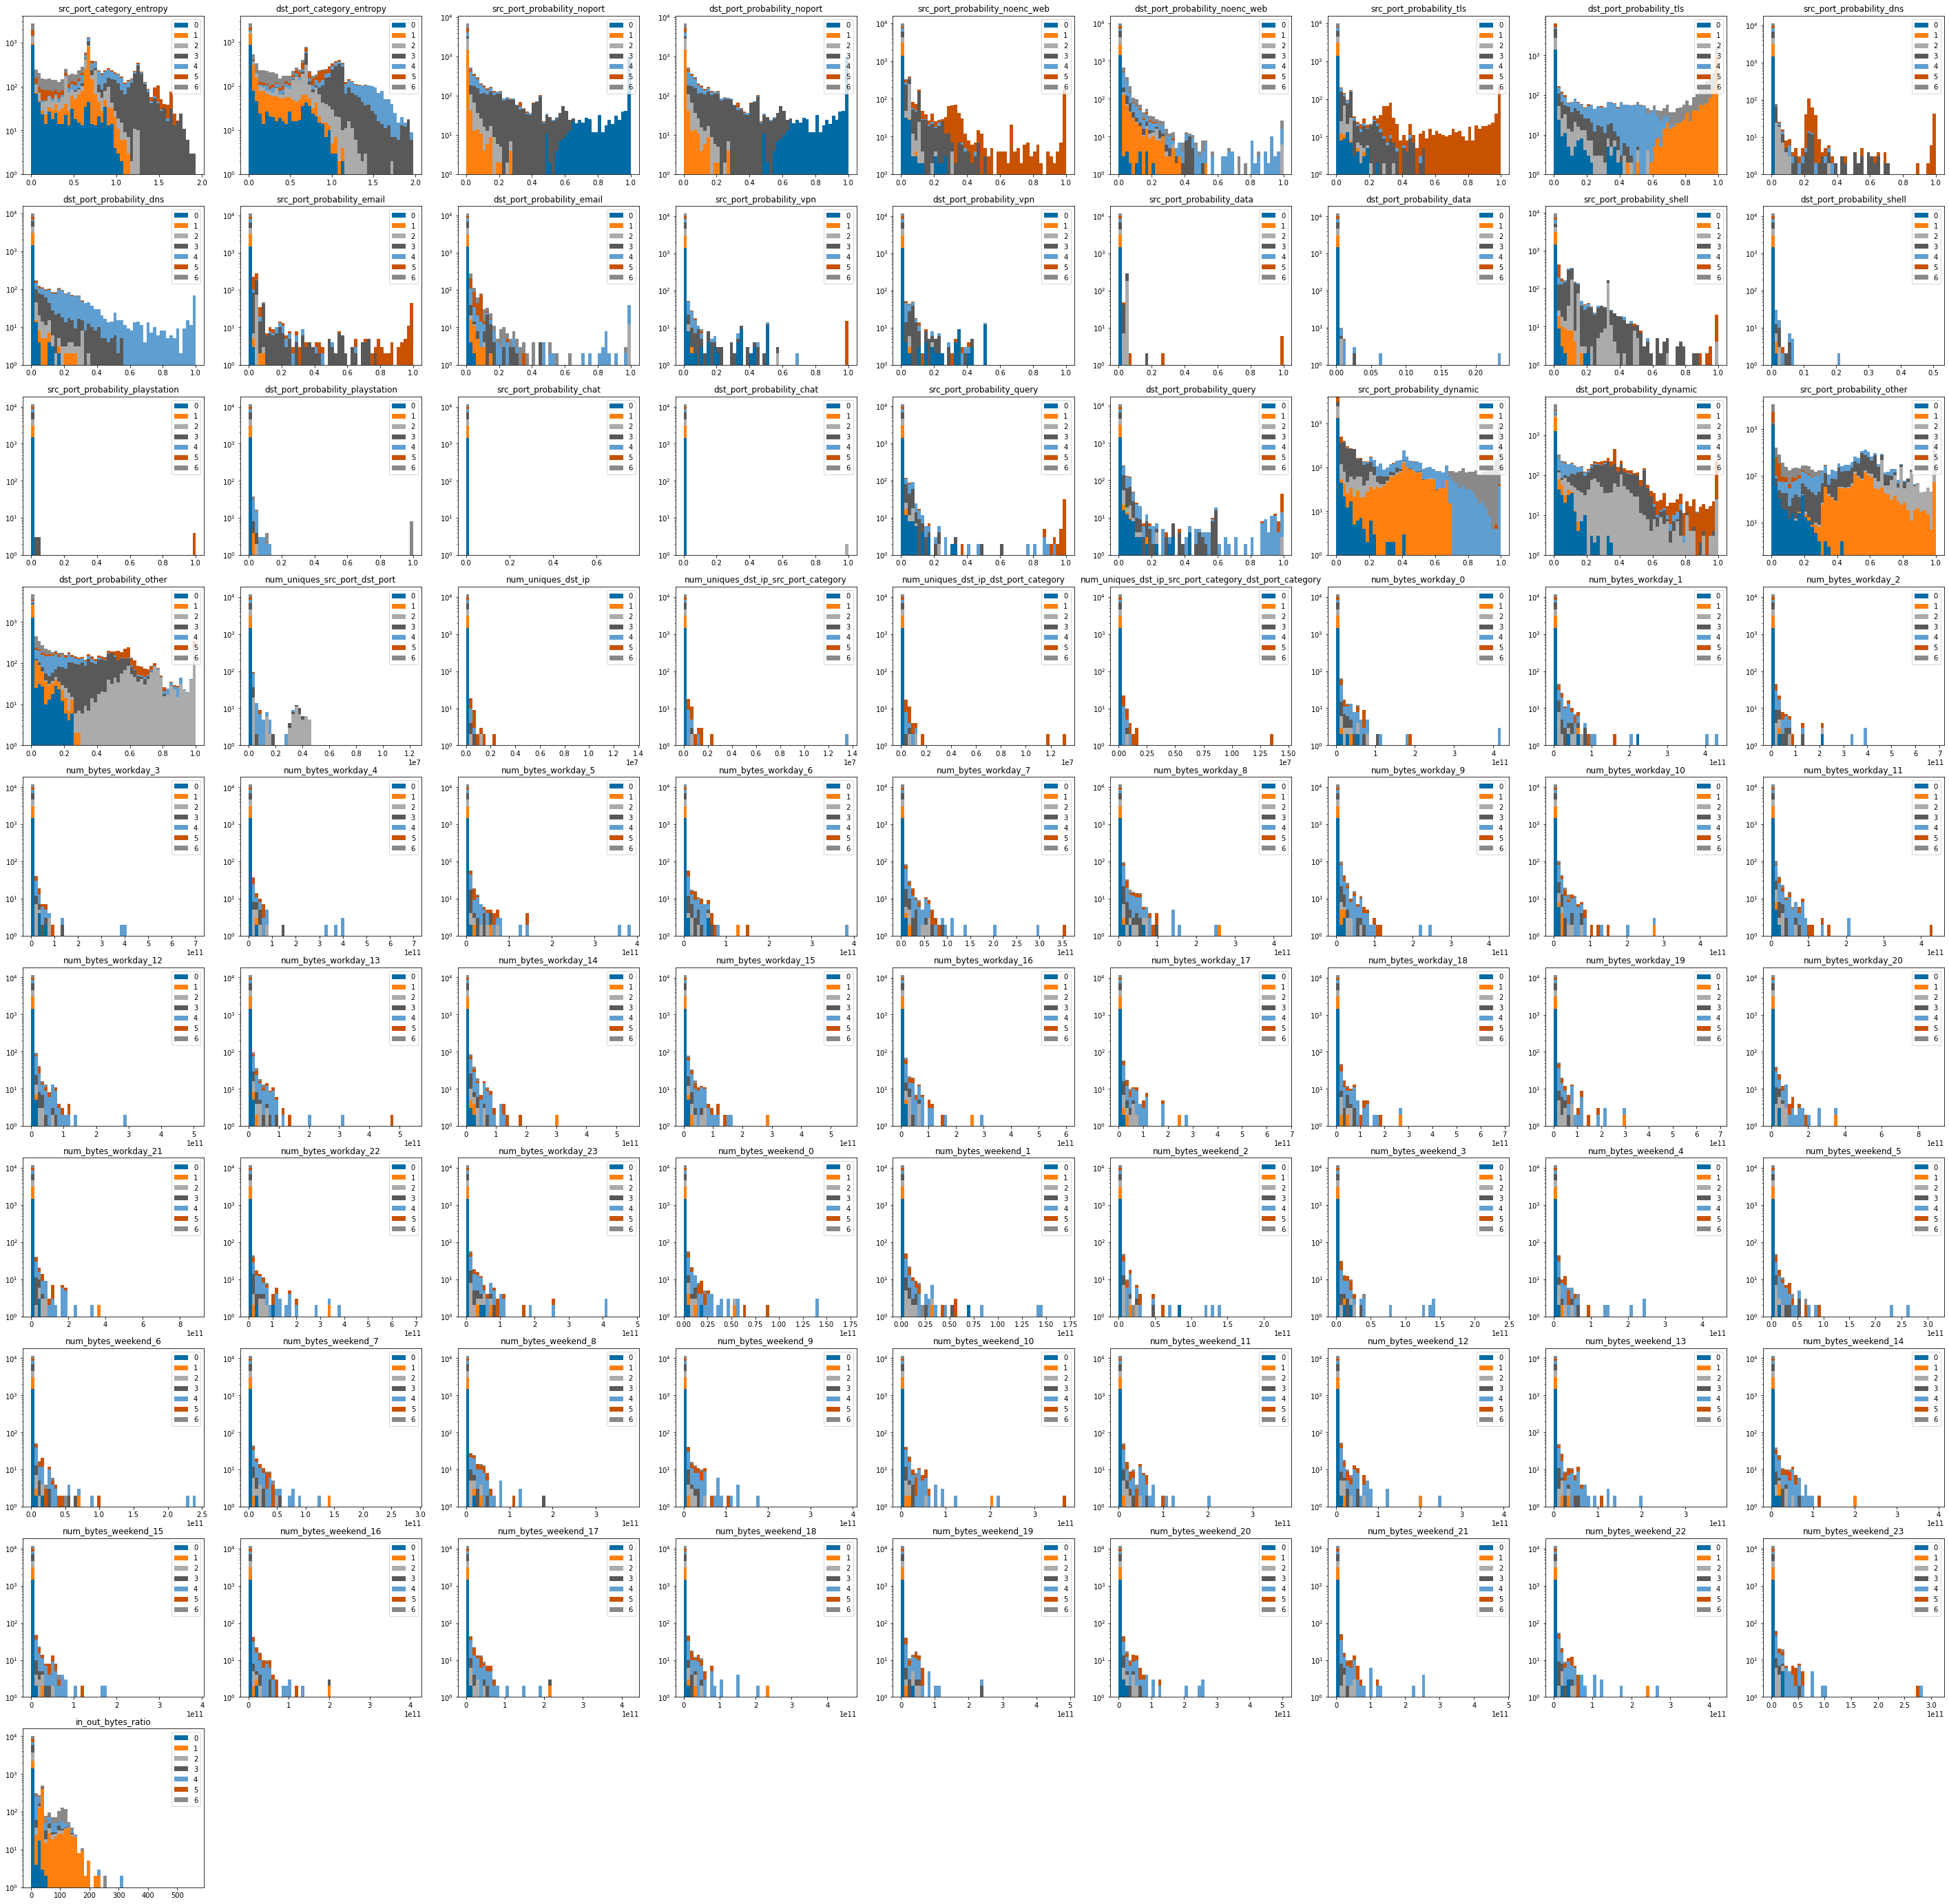

In [42]:
n_rows = math.floor(math.sqrt(len(columns_to_plot))) + 1
n_cols = n_rows - 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 50))

for i, col_name in enumerate(columns_to_plot):
    ax_row = i // n_cols
    ax_col = i % n_cols

    ax = axes[ax_row][ax_col]

    data = np.array(
        [
            df_features_filtered[df_features_filtered['cluster_label_all_features'] == label][col_name].to_numpy()
            for label in unique_cluster_labels
        ],
        dtype='object')

    ax.hist(data, bins=50, log=True, label=unique_cluster_labels, stacked=True)
    ax.legend(loc='upper right')
    ax.title.set_text(col_name)

for i in range(len(columns_to_plot), n_rows * n_cols):
    ax_row = i // n_cols
    ax_col = i % n_cols
    fig.delaxes(axes[ax_row][ax_col])

### Distributions per cluster, no bytes-based features

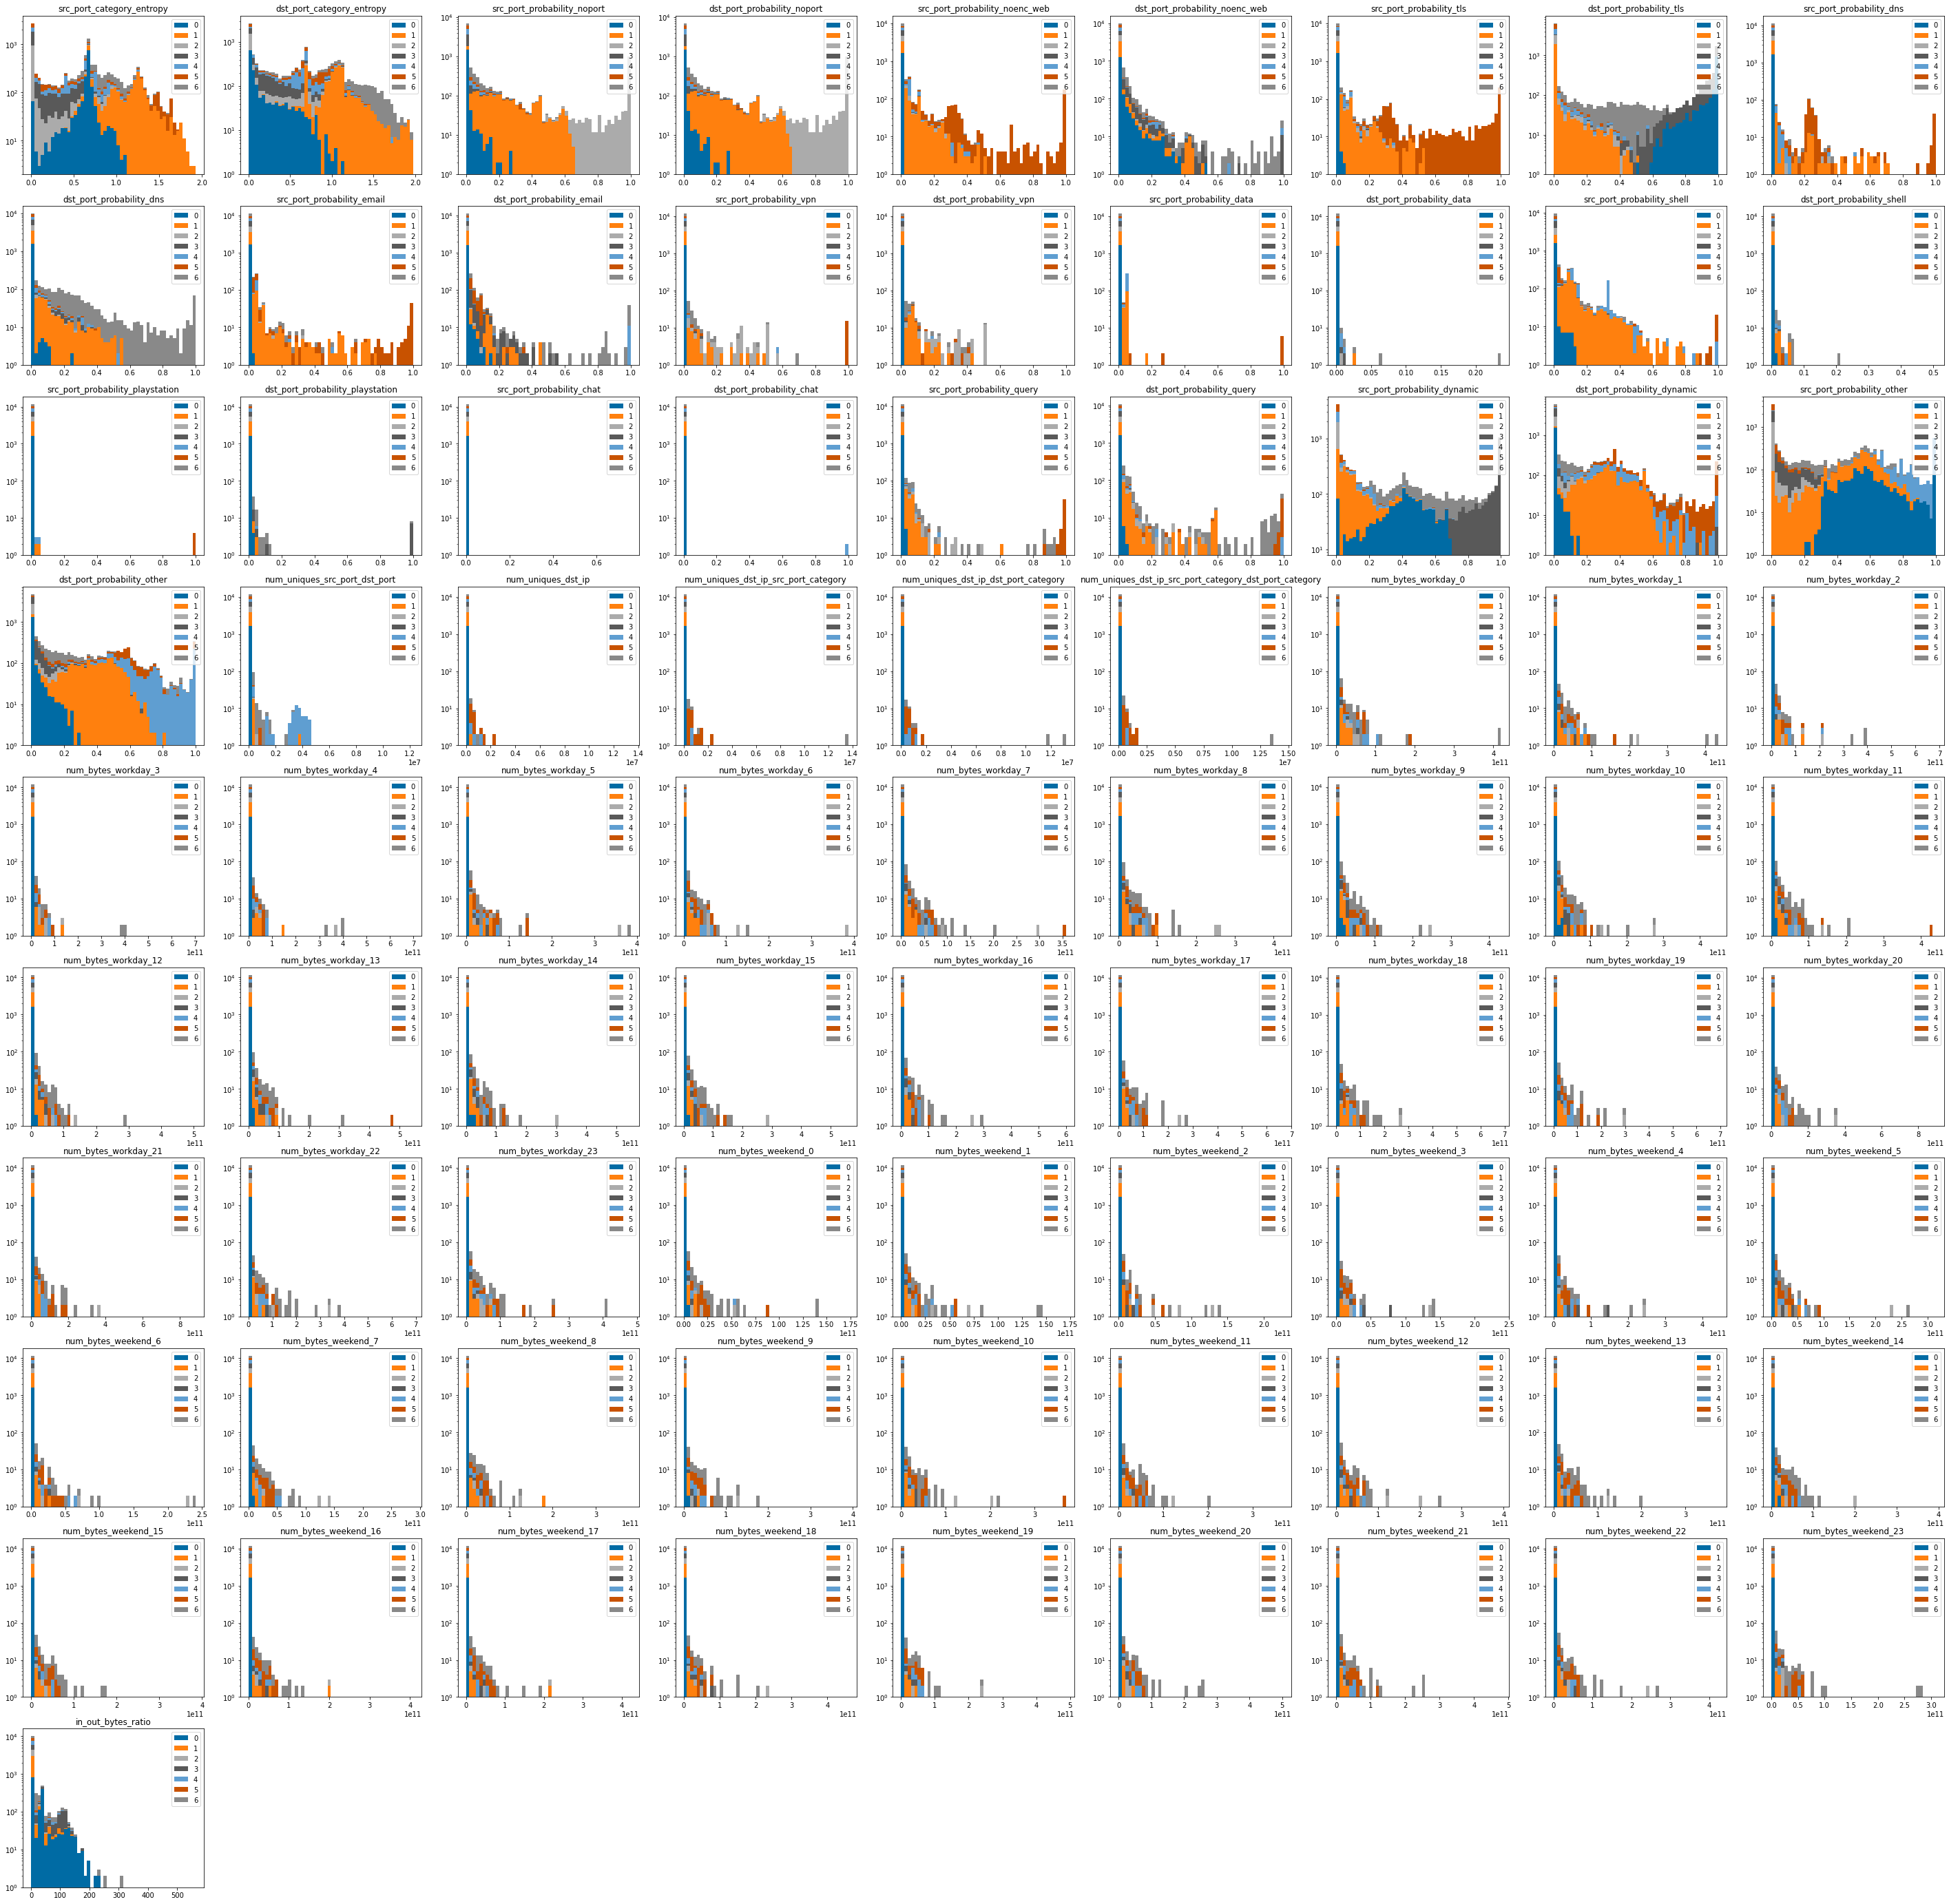

In [43]:
n_rows = math.floor(math.sqrt(len(columns_to_plot))) + 1
n_cols = n_rows - 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 50))

unique_cluster_labels = df_features_filtered['cluster_label_no_bytes_based_features'].unique()
unique_cluster_labels = np.sort(unique_cluster_labels)

for i, col_name in enumerate(columns_to_plot):
    ax_row = i // n_cols
    ax_col = i % n_cols

    ax = axes[ax_row][ax_col]

    data = np.array(
        [
            df_features_filtered[df_features_filtered['cluster_label_no_bytes_based_features'] == label][col_name].to_numpy()
            for label in unique_cluster_labels
        ],
        dtype='object')

    ax.hist(data, bins=50, log=True, label=unique_cluster_labels, stacked=True)
    ax.legend(loc='upper right')
    ax.title.set_text(col_name)

for i in range(len(columns_to_plot), n_rows * n_cols):
    ax_row = i // n_cols
    ax_col = i % n_cols
    fig.delaxes(axes[ax_row][ax_col])

## Scaled

In [91]:
def transform_pos_to_pos_and_neg(array):
    # While no division by zero occurs, the warning is displayed anyway.
    # Source: https://stackoverflow.com/questions/64747346/numpy-divide-by-zero-encountered-in-true-divide-on-np-where
    with np.errstate(divide='ignore'):
        array = np.where((array > 0) & (array <= 1), -1 / array + 1, array)
    array = np.where(array > 1, array - 1, array)
    
    return array

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4324263550>,
      dtype=object)

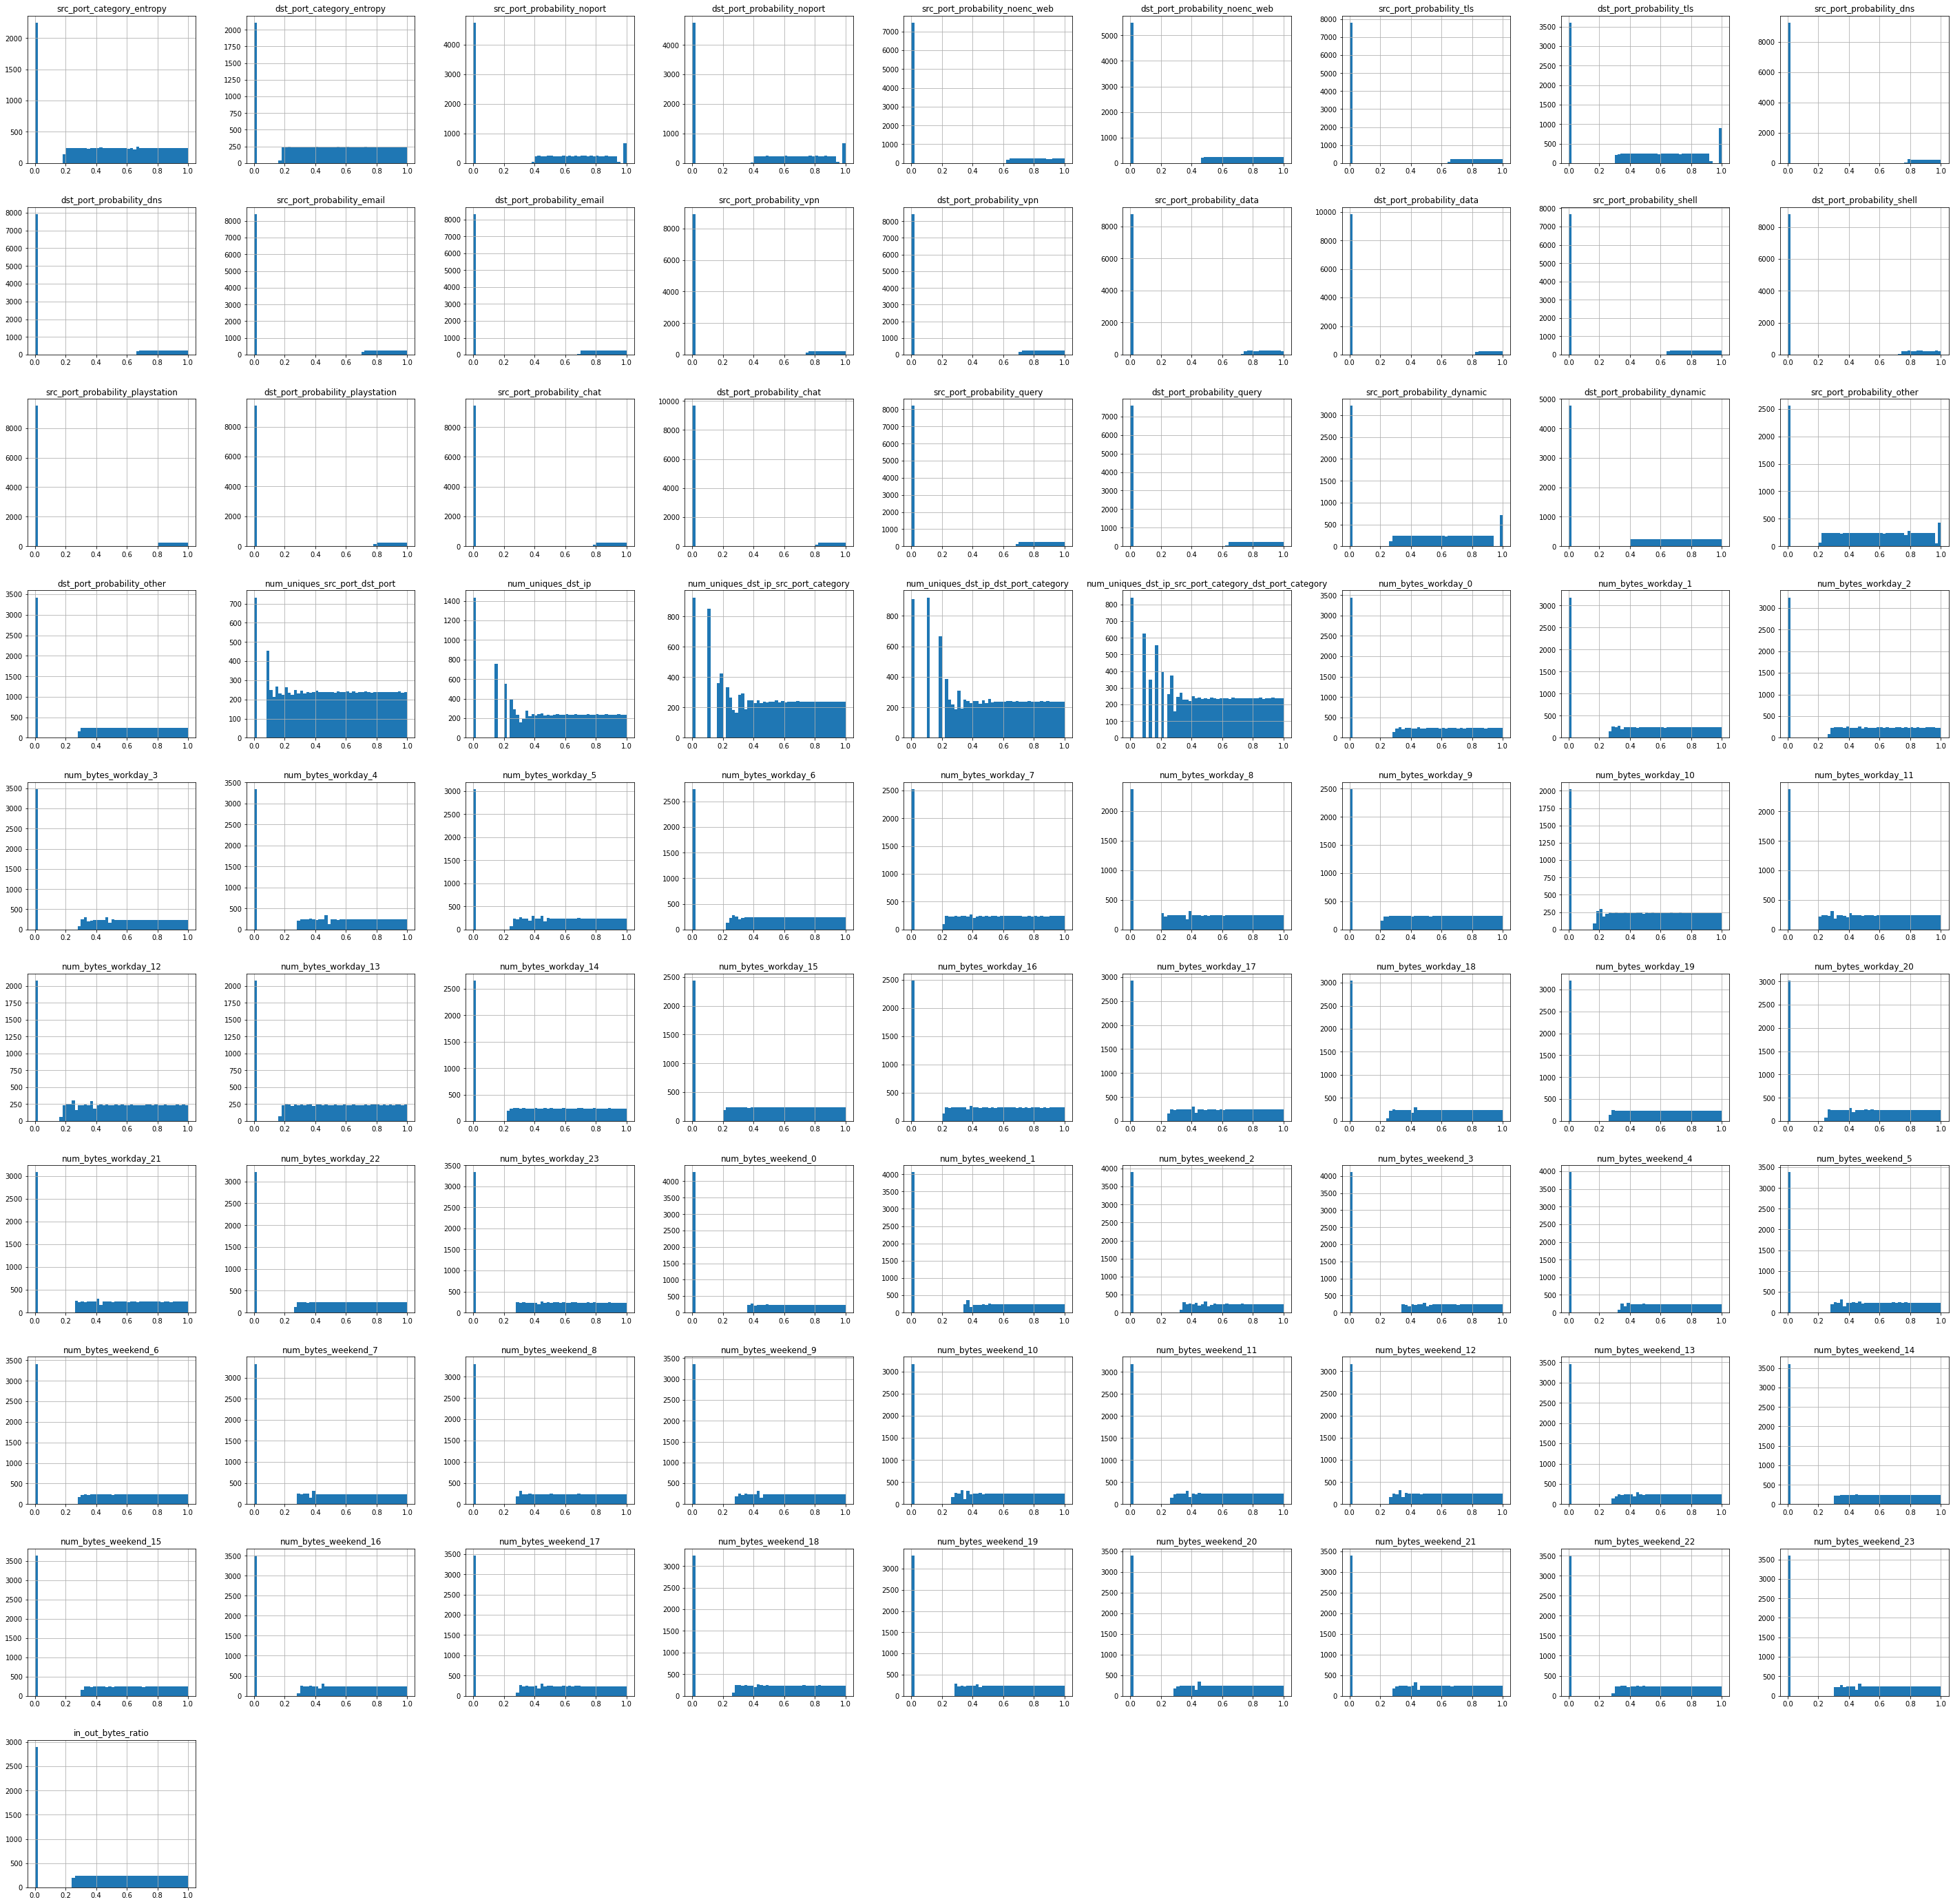

In [ ]:
scaler = sklearn_preprocessing.QuantileTransformer(n_quantiles=1000)

df_features_scaled = pd.DataFrame(
    scaler.fit_transform(df_features_filtered[columns_to_plot].to_numpy()), columns=columns_to_plot, index=df_features_filtered.index)
df_features_scaled.hist(bins=50, figsize=(50, 50))

Distributions per category (SH vs. NET):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f431f52e5e0>,
      dtype=object)

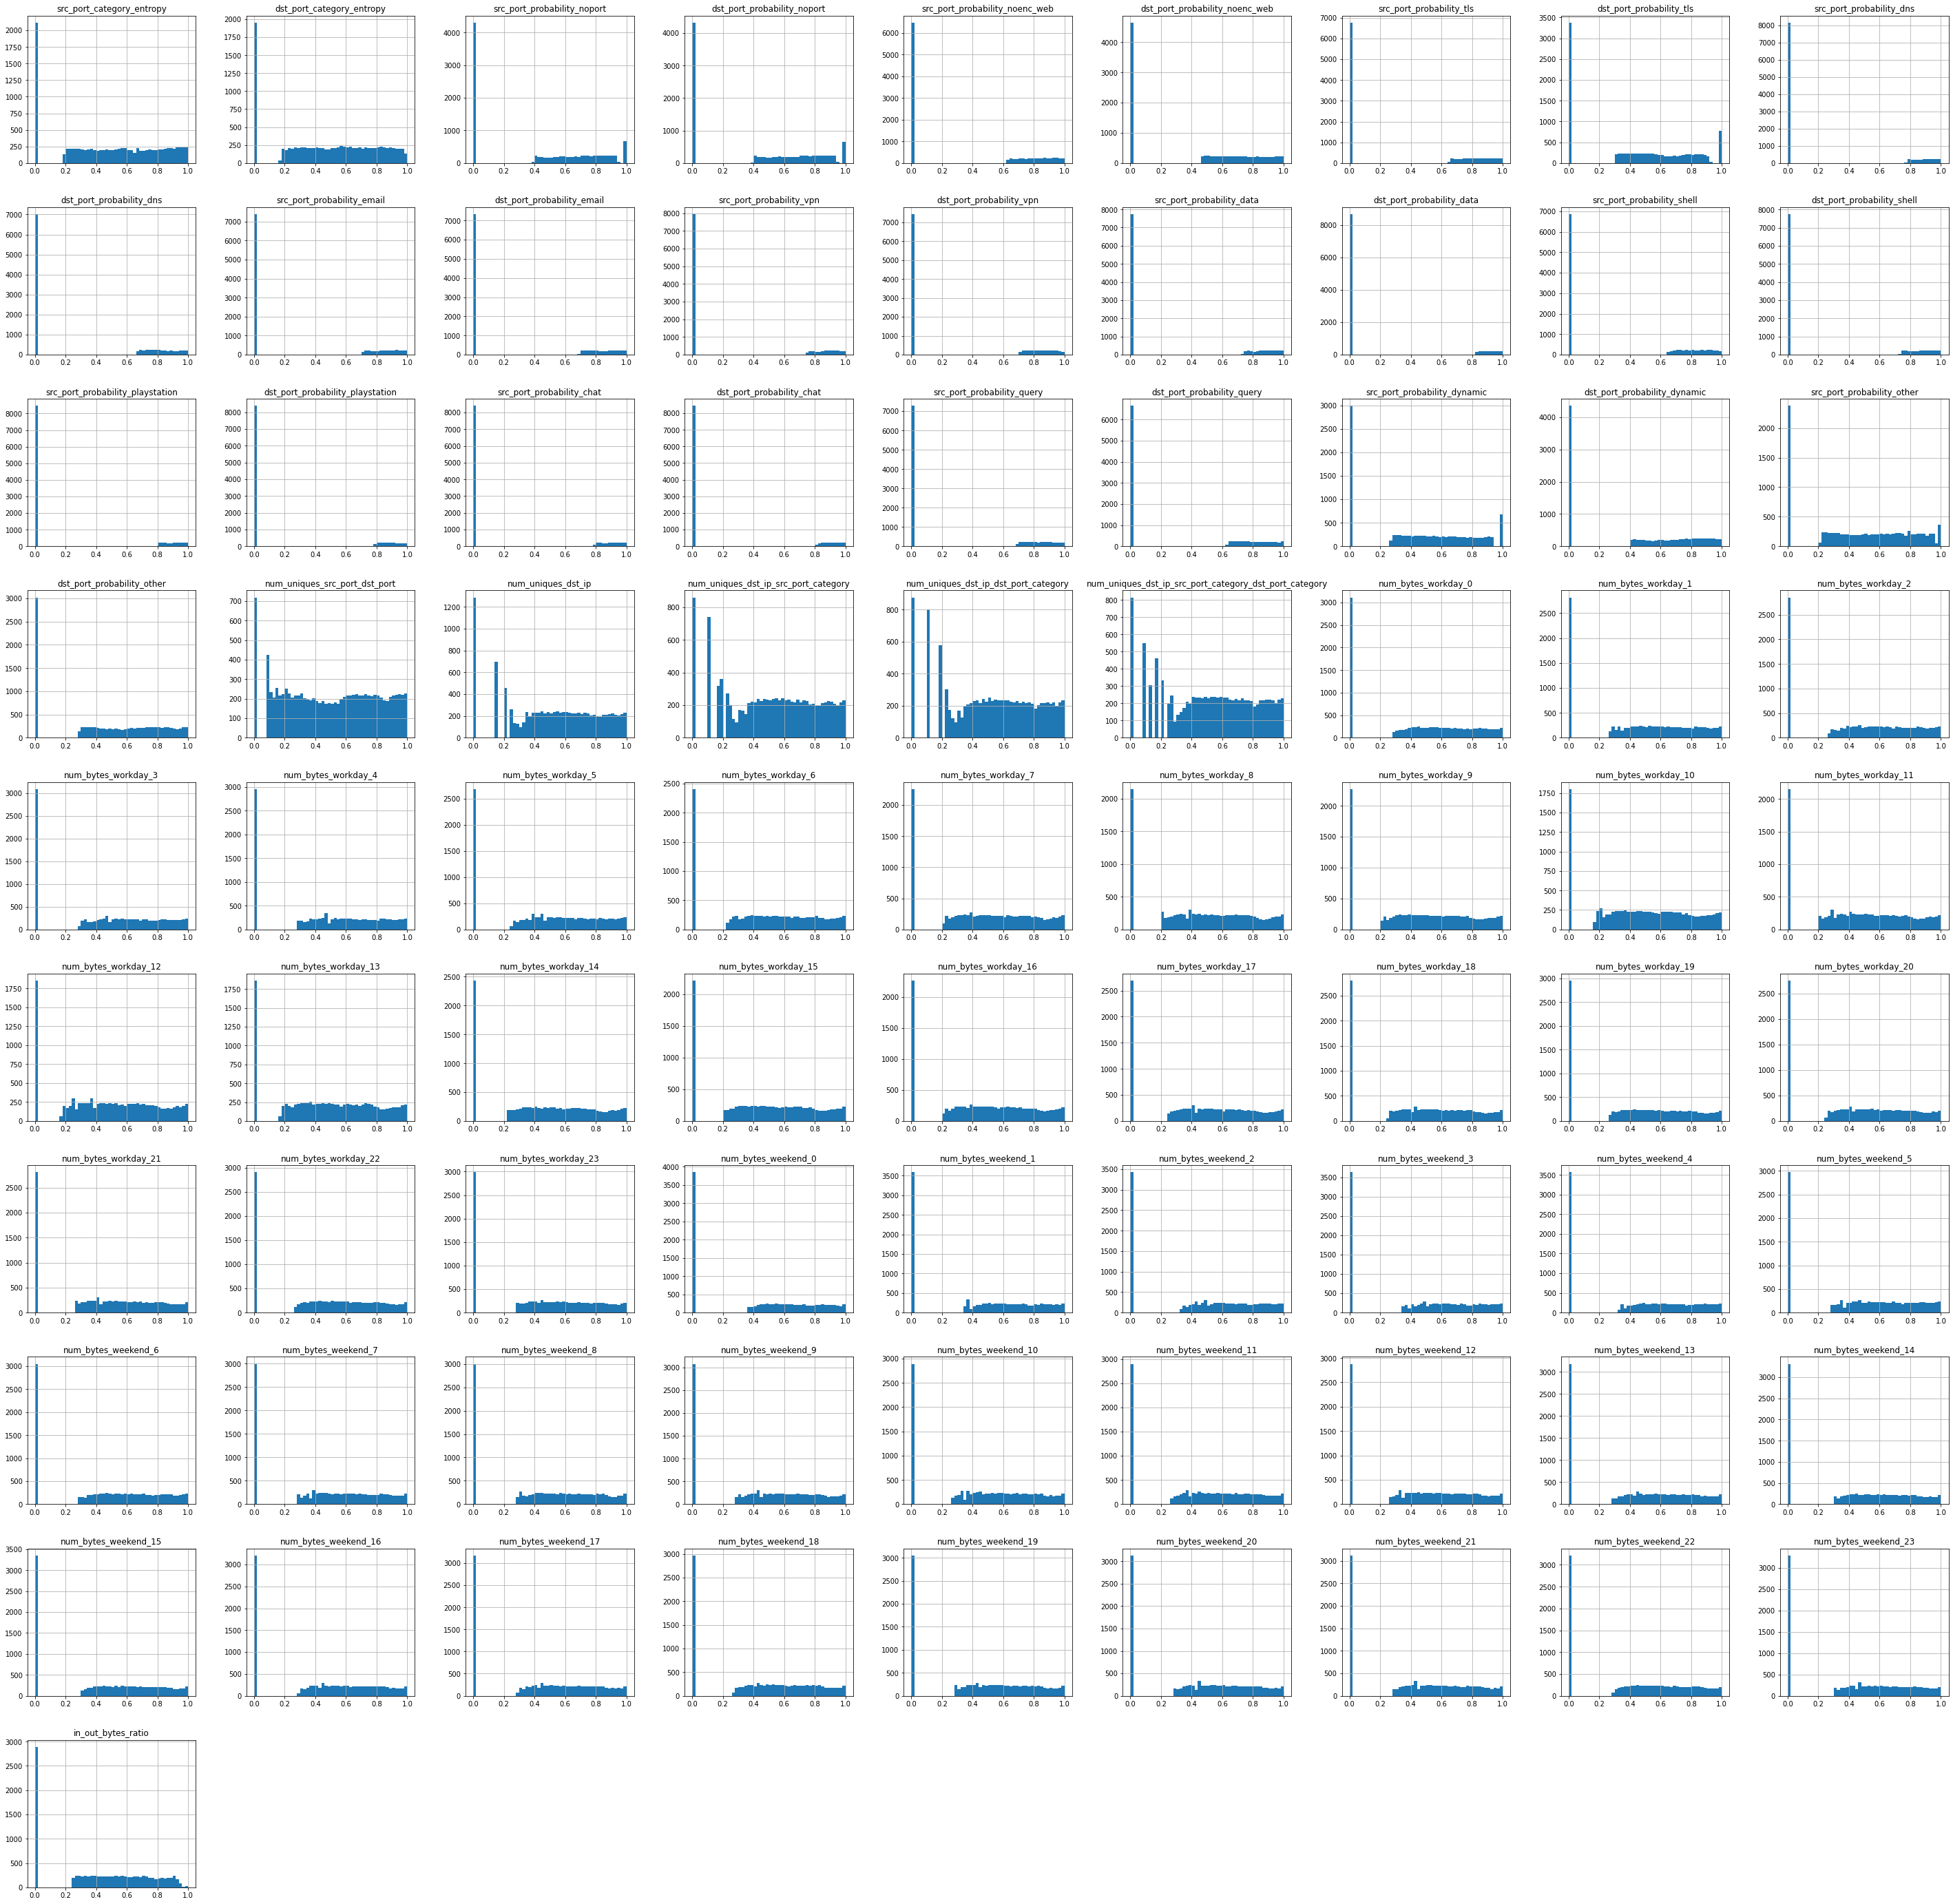

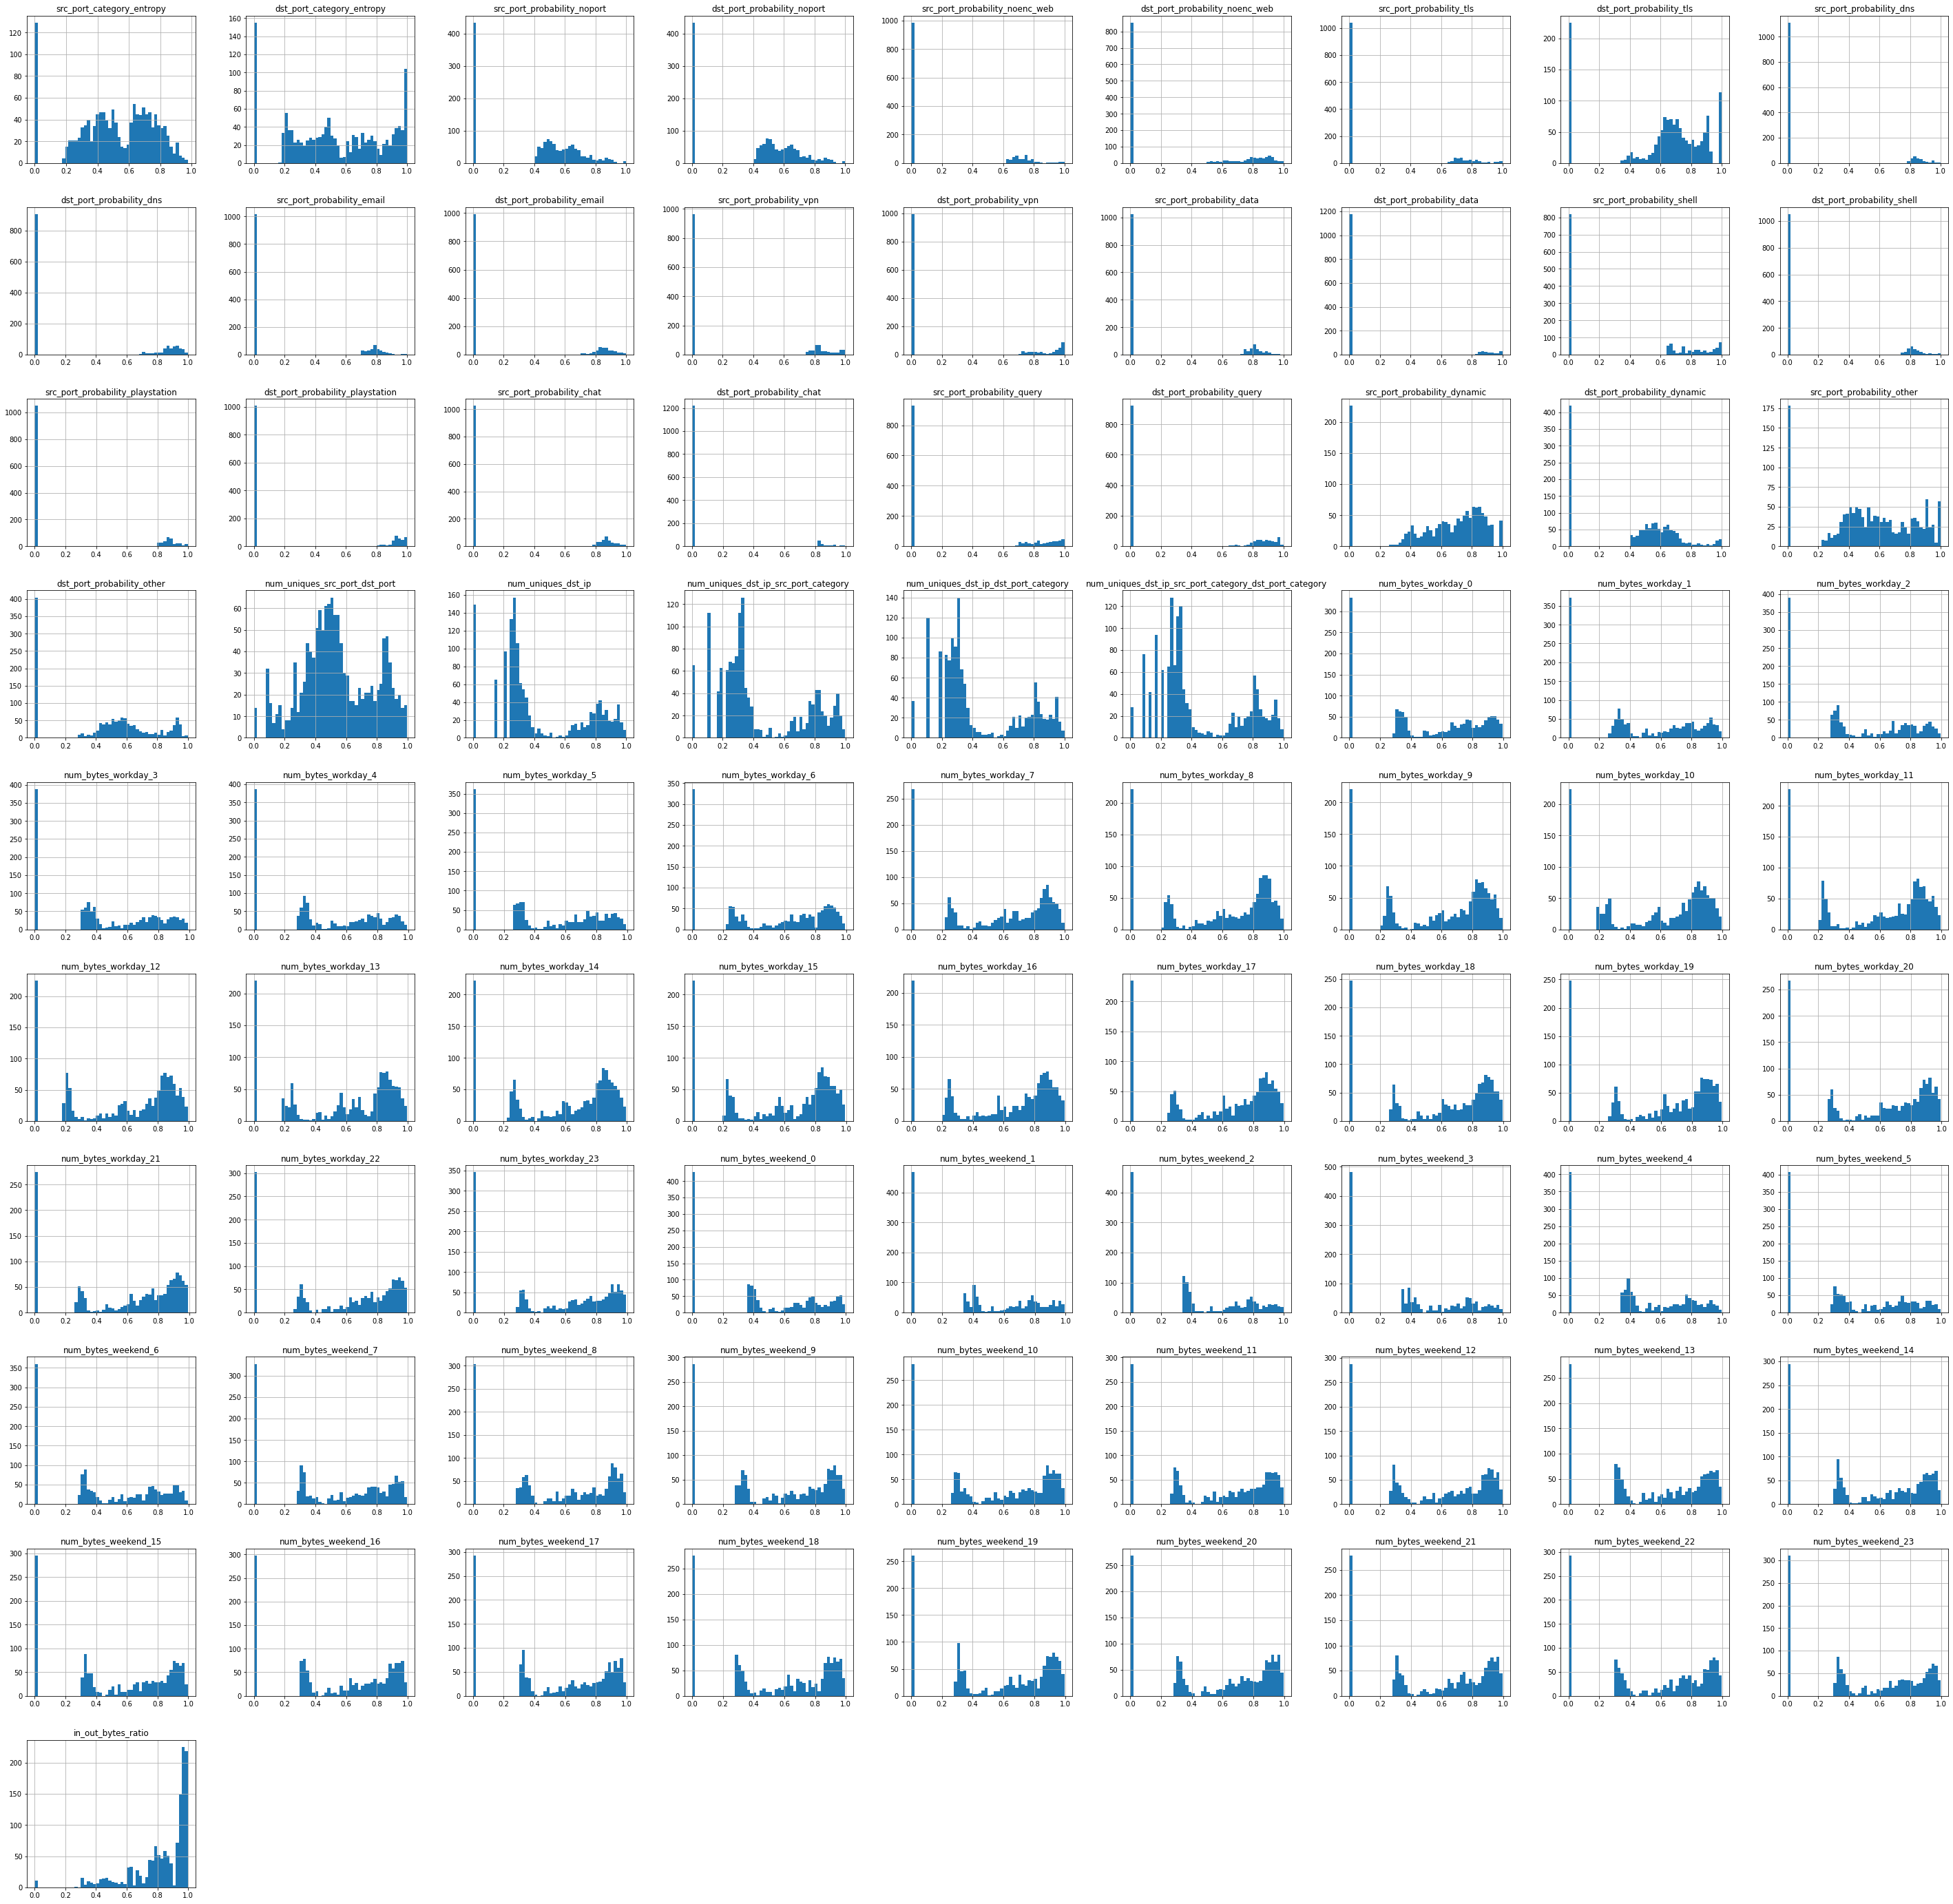

In [ ]:
scaler = sklearn_preprocessing.QuantileTransformer(n_quantiles=1000)

df_features_scaled = pd.DataFrame(
    scaler.fit_transform(df_features_filtered[columns_to_plot].to_numpy()), columns=columns_to_plot, index=df_features_filtered.index)
df_features_scaled[df_features_filtered['category'] == 'SH'].hist(bins=50, figsize=(50, 50))
df_features_scaled[df_features_filtered['category'] == 'NET'].hist(bins=50, figsize=(50, 50))

Transforming to a normal distribution is probably not desirable due to zero/very low values being prevalent:

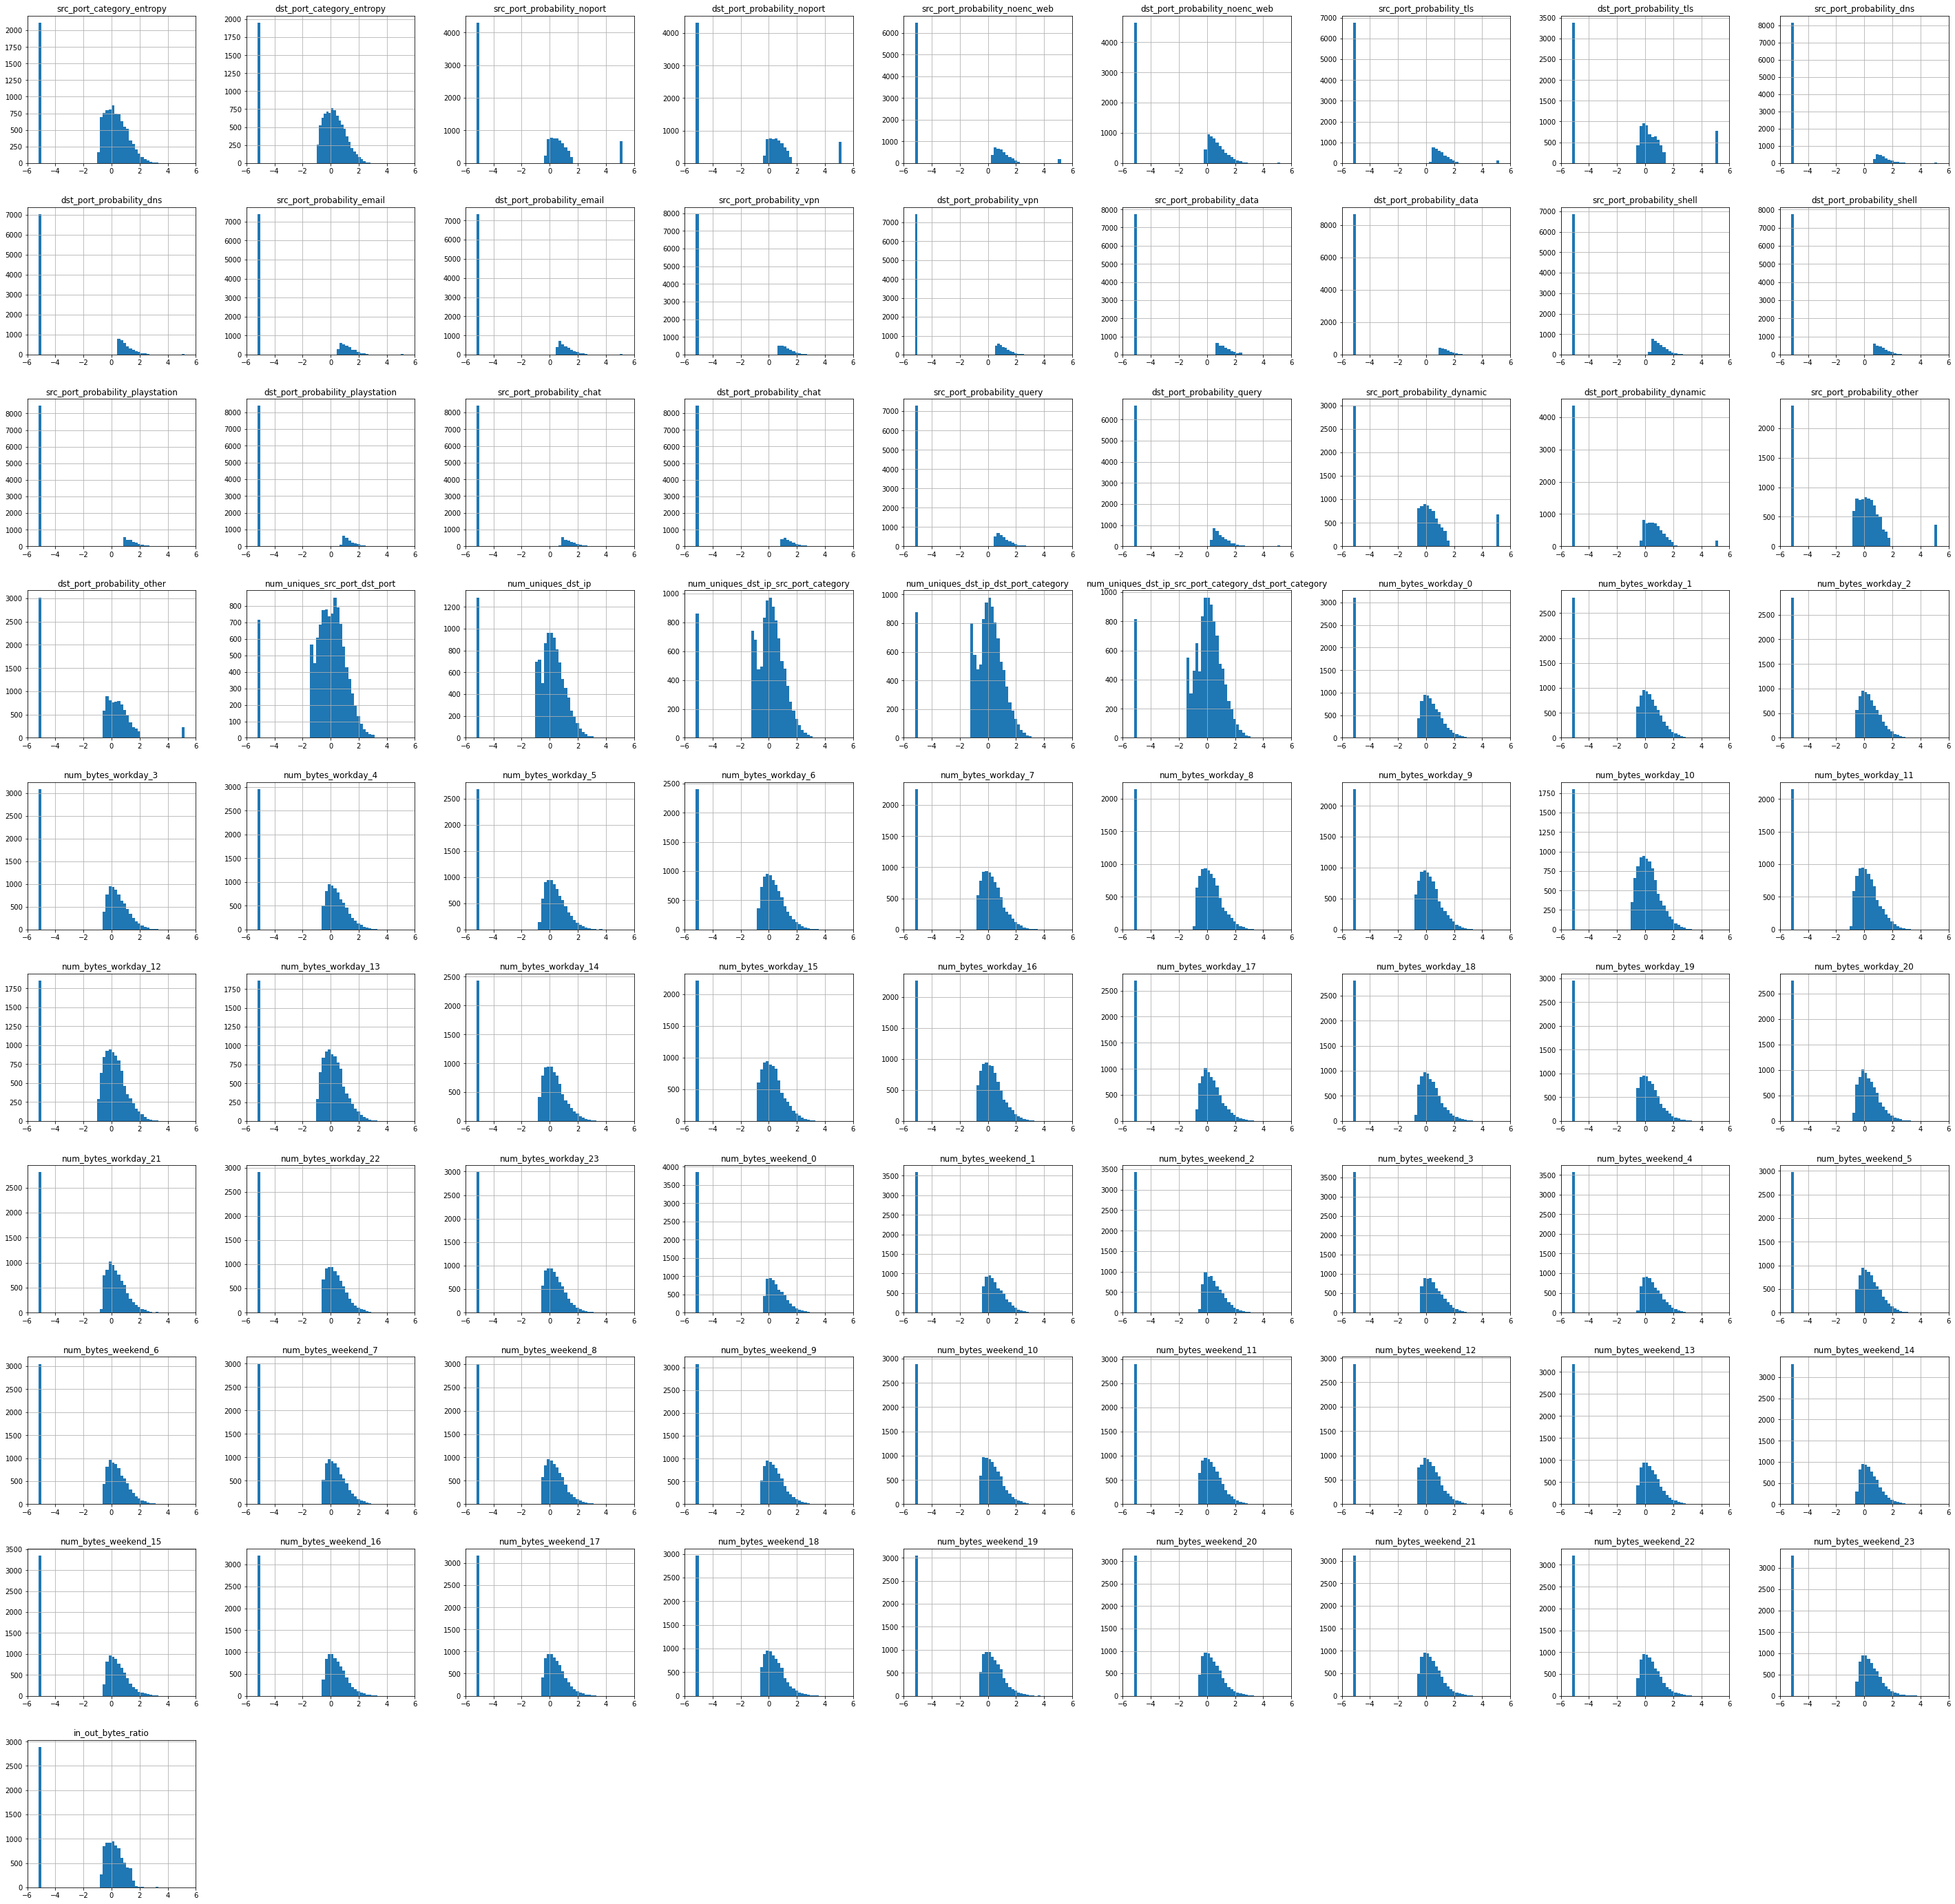

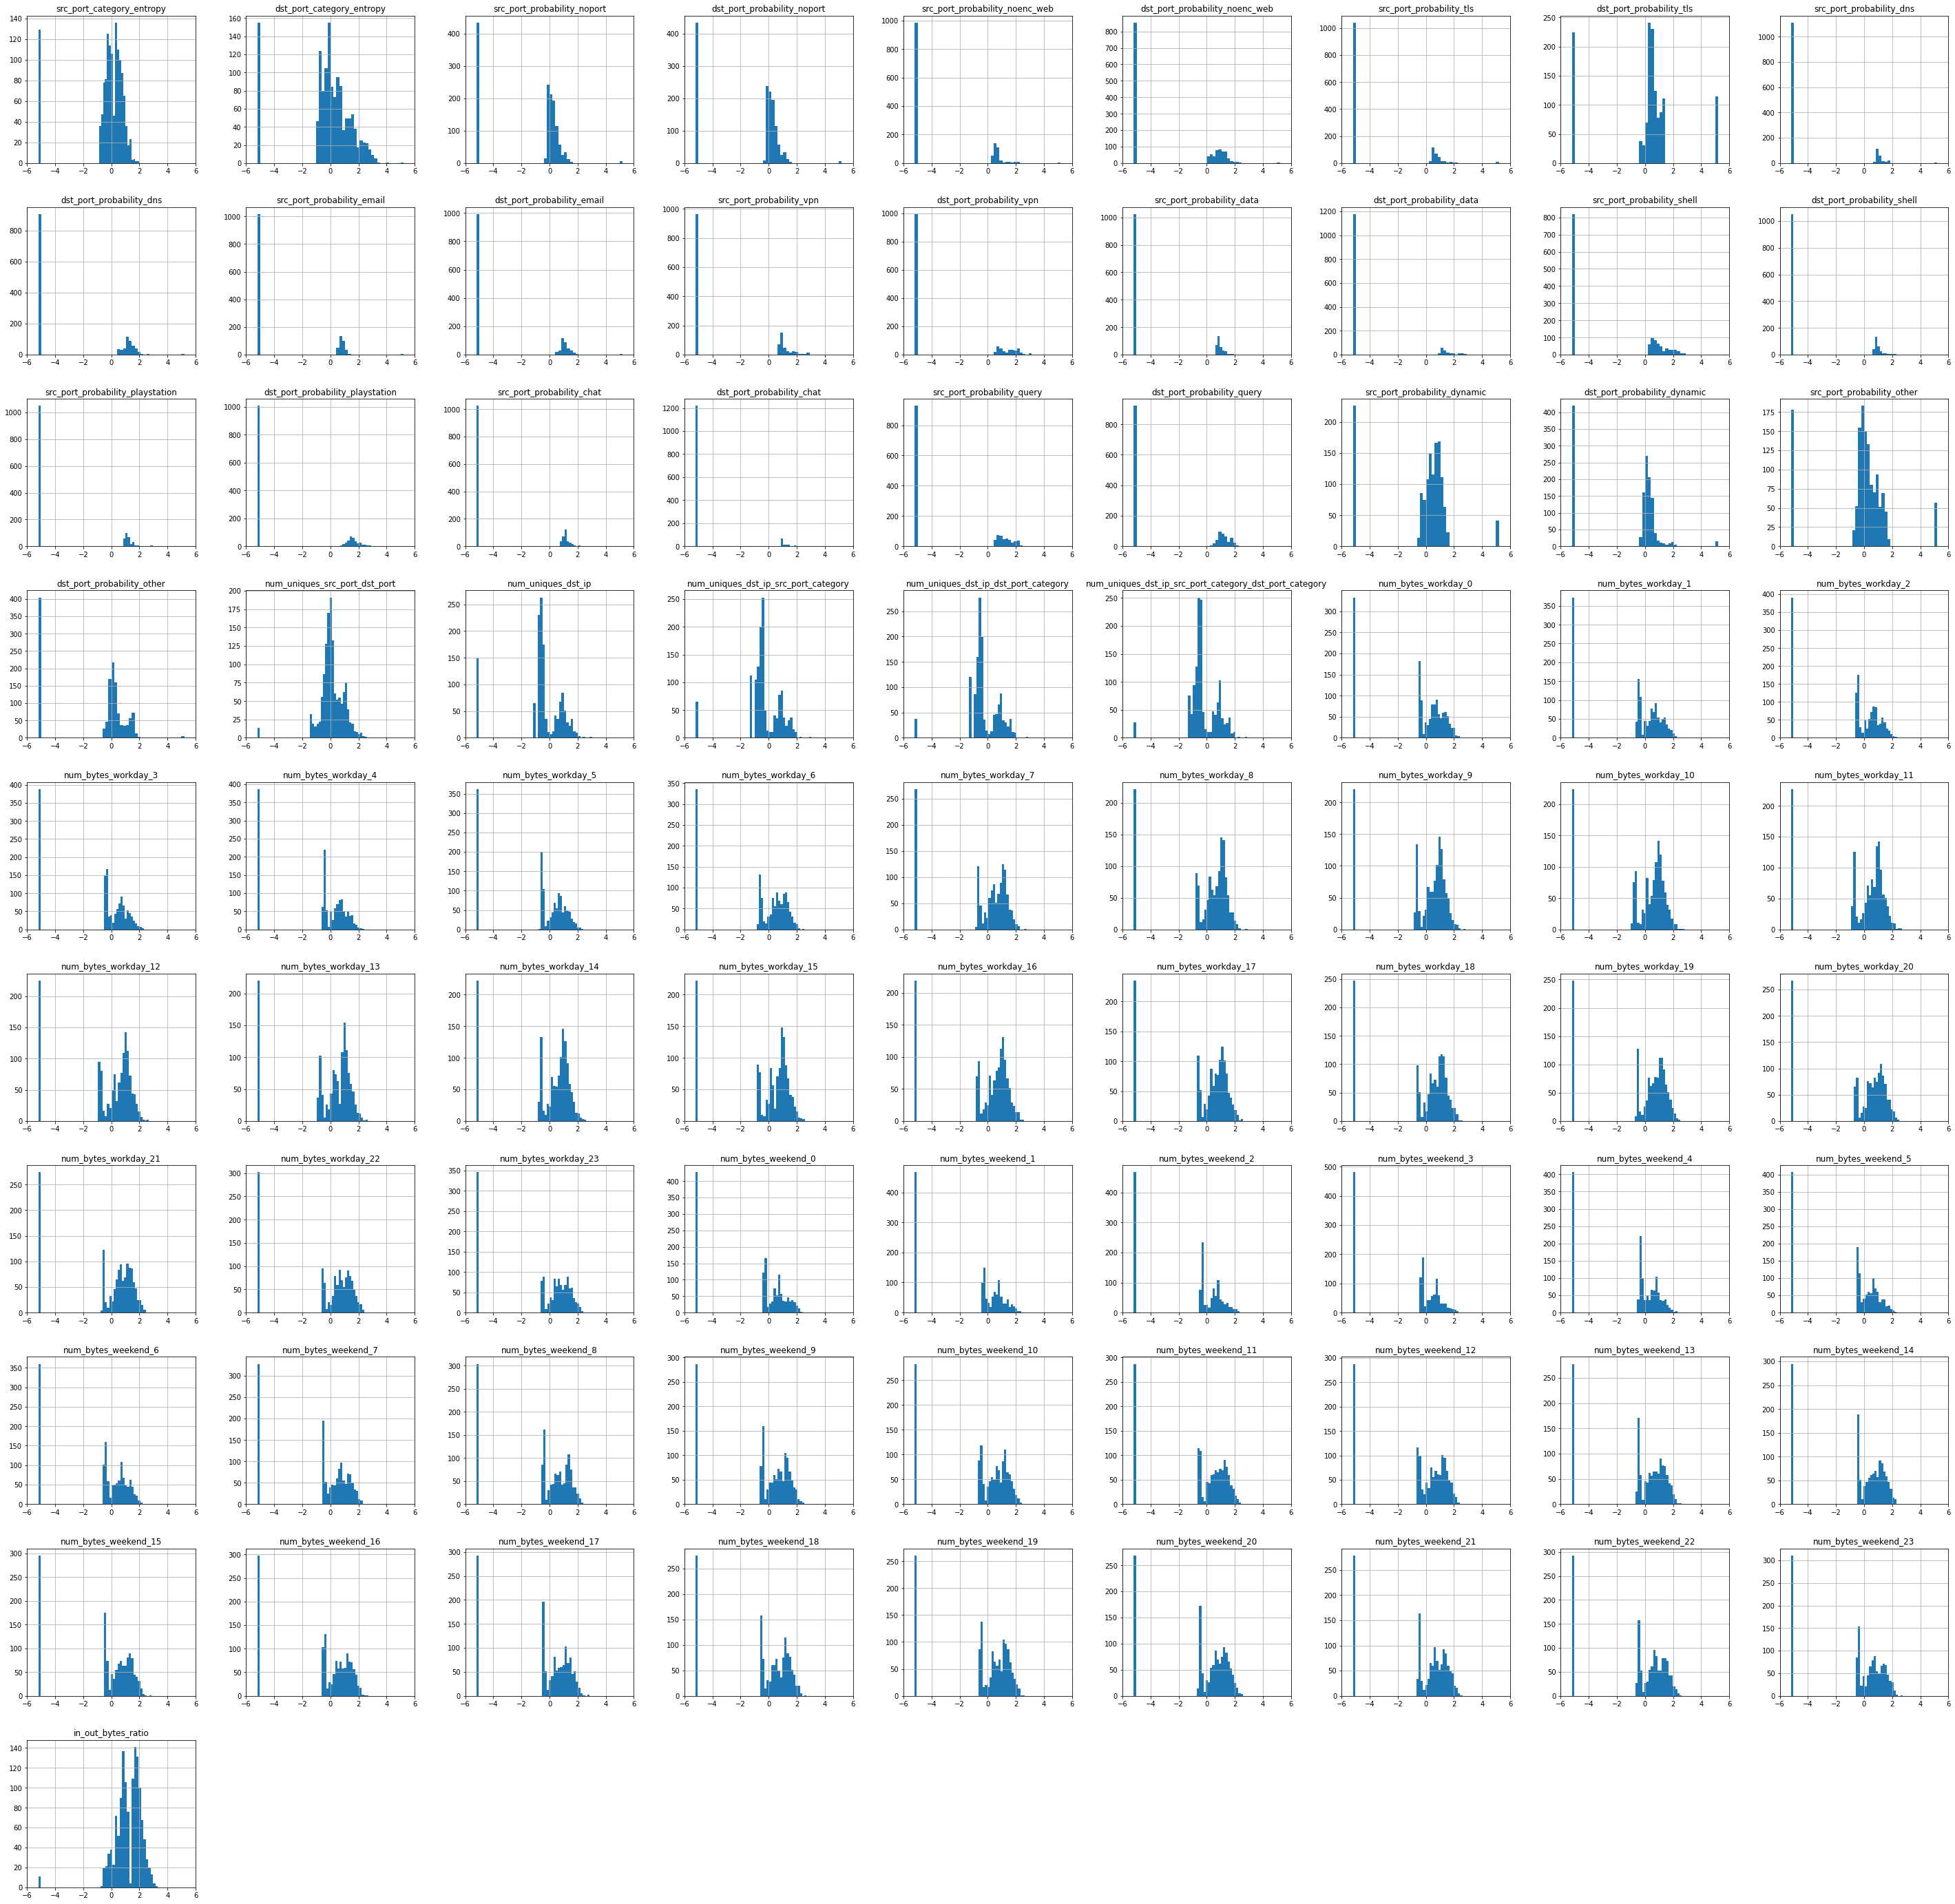

In [ ]:
scaler = sklearn_preprocessing.QuantileTransformer(n_quantiles=1000, output_distribution='normal')

df_features_scaled = pd.DataFrame(
    scaler.fit_transform(df_features_filtered[columns_to_plot].to_numpy()), columns=columns_to_plot, index=df_features_filtered.index)

axes = df_features_scaled[df_features_filtered['category'] == 'SH'].hist(bins=50, figsize=(50, 50))
for ax in axes.flatten():
    ax.set_xlim((-6, 6))

axes = df_features_scaled[df_features_filtered['category'] == 'NET'].hist(bins=50, figsize=(50, 50))
for ax in axes.flatten():
    ax.set_xlim((-6, 6))

Let's try a custom transformation that hopefully better distinguishes categories of nodes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae07e8faf0>,
      dtype=object)

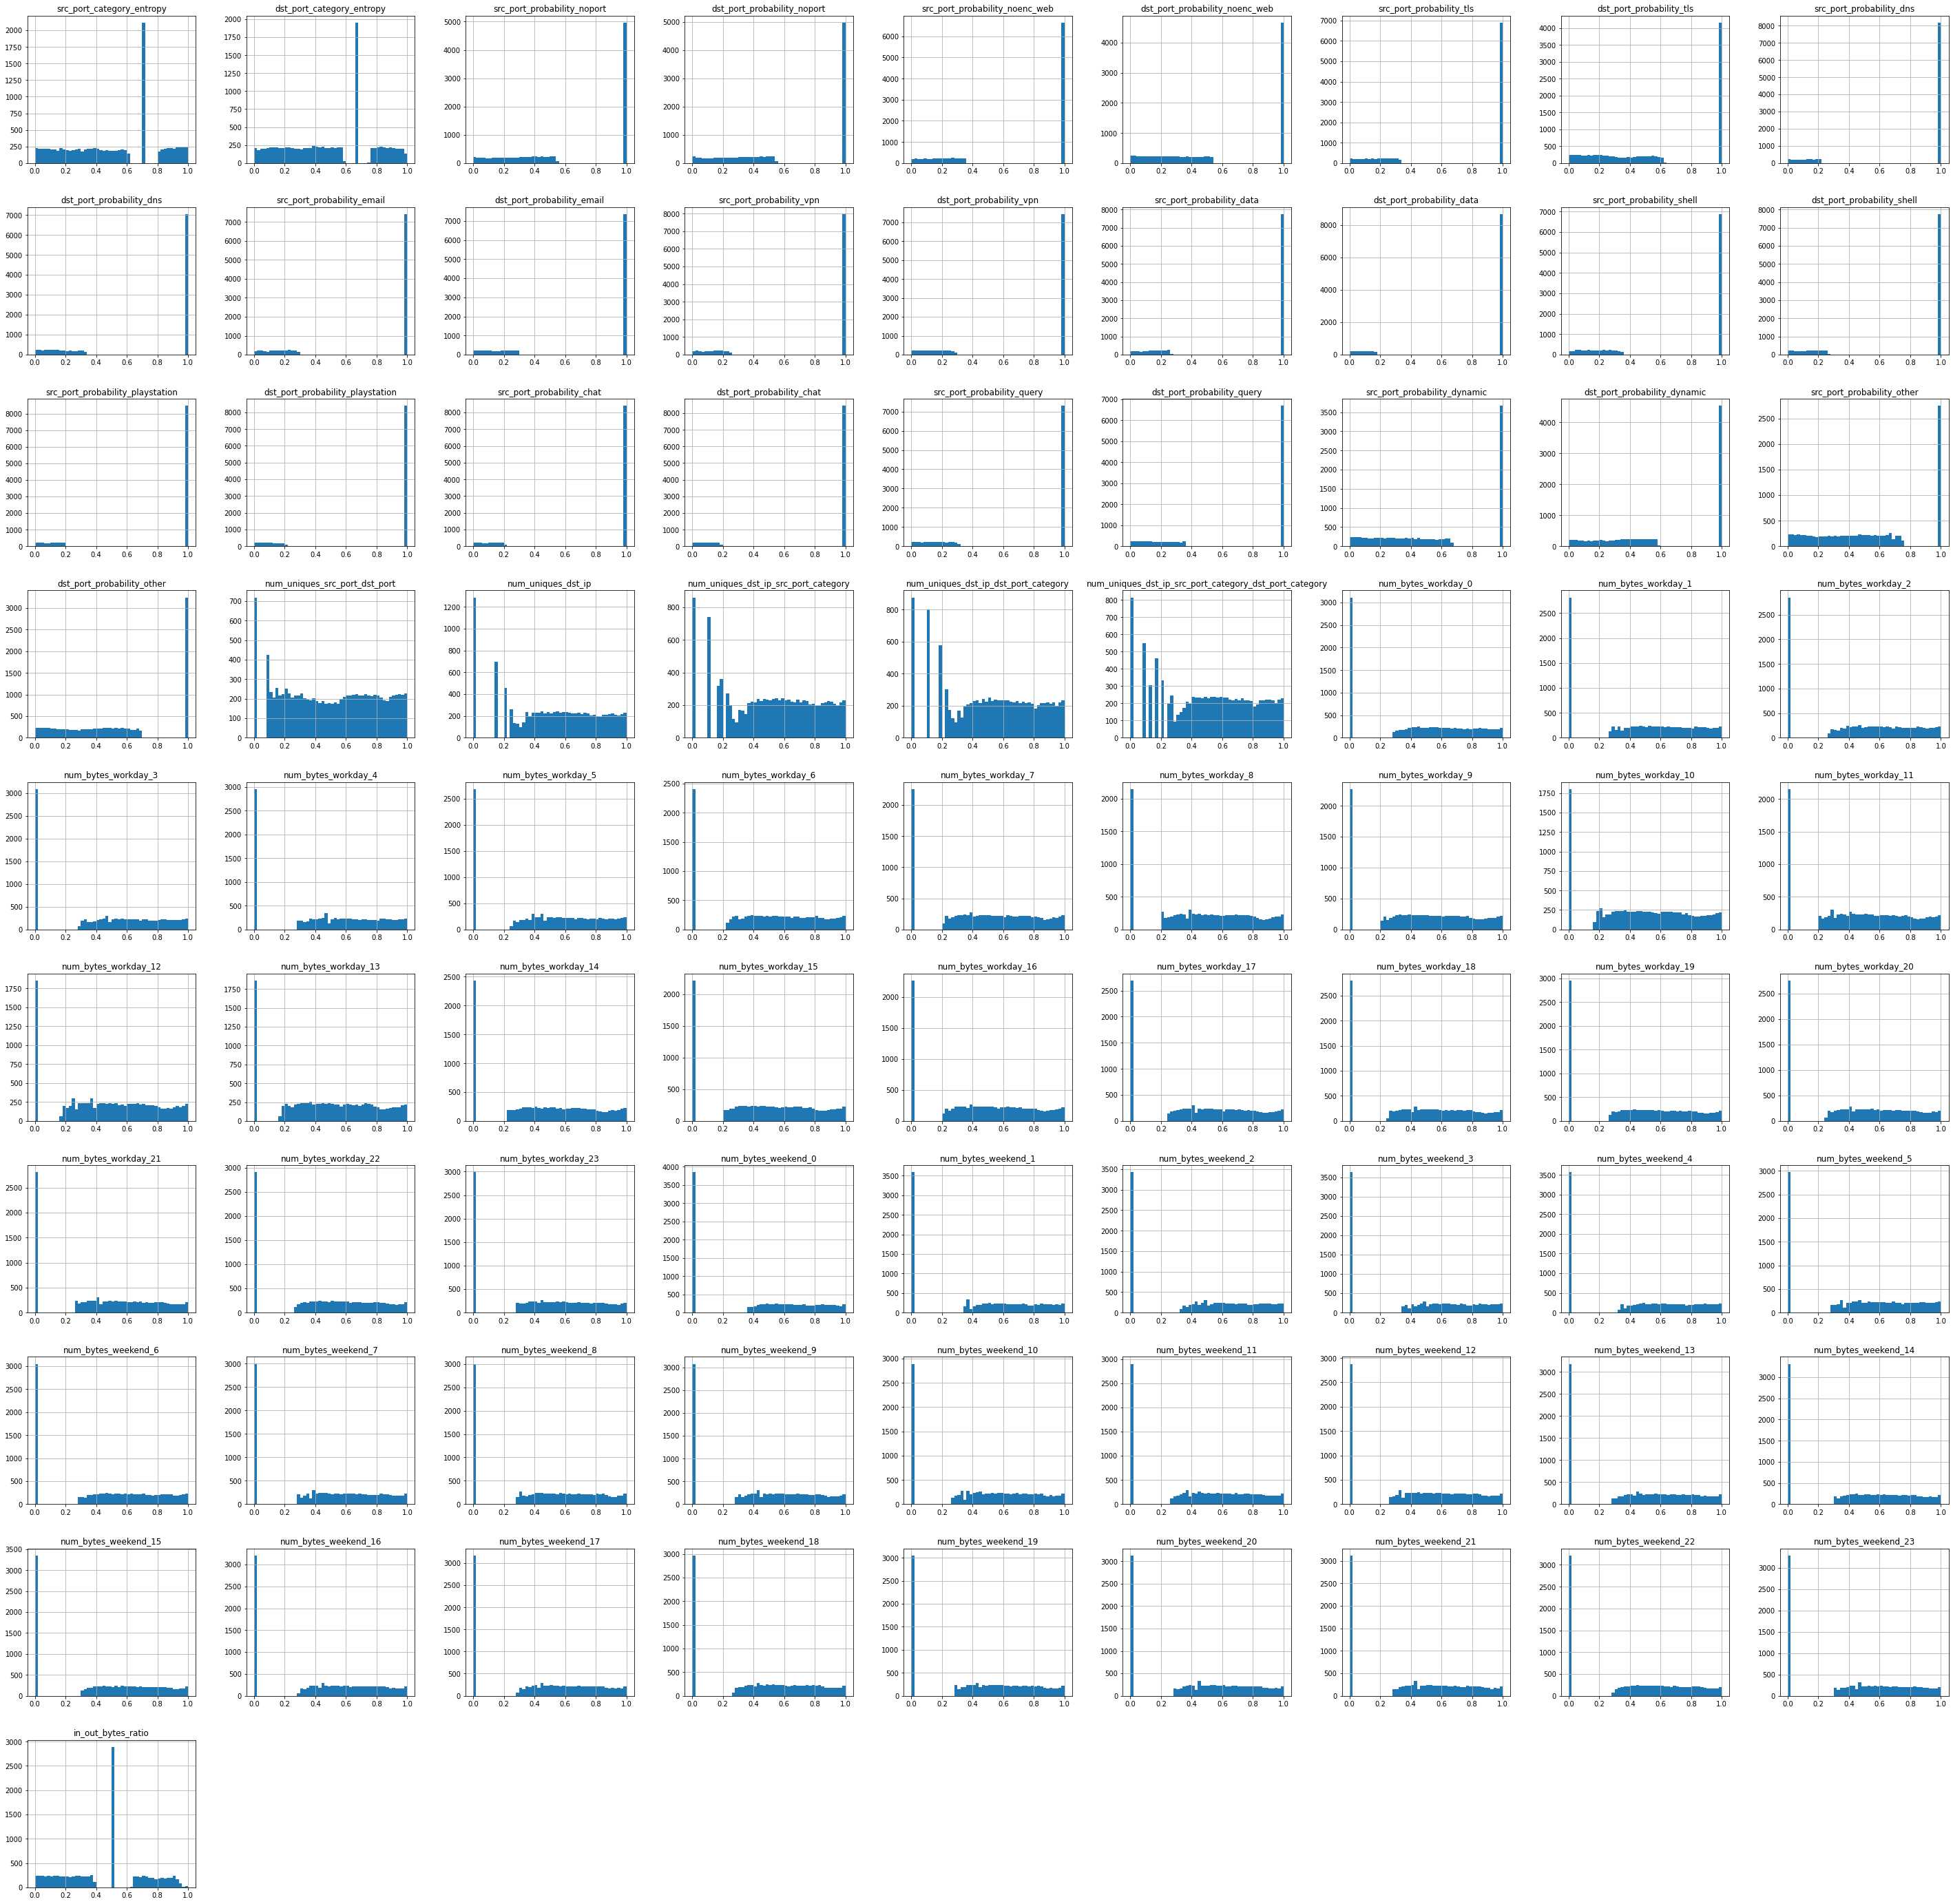

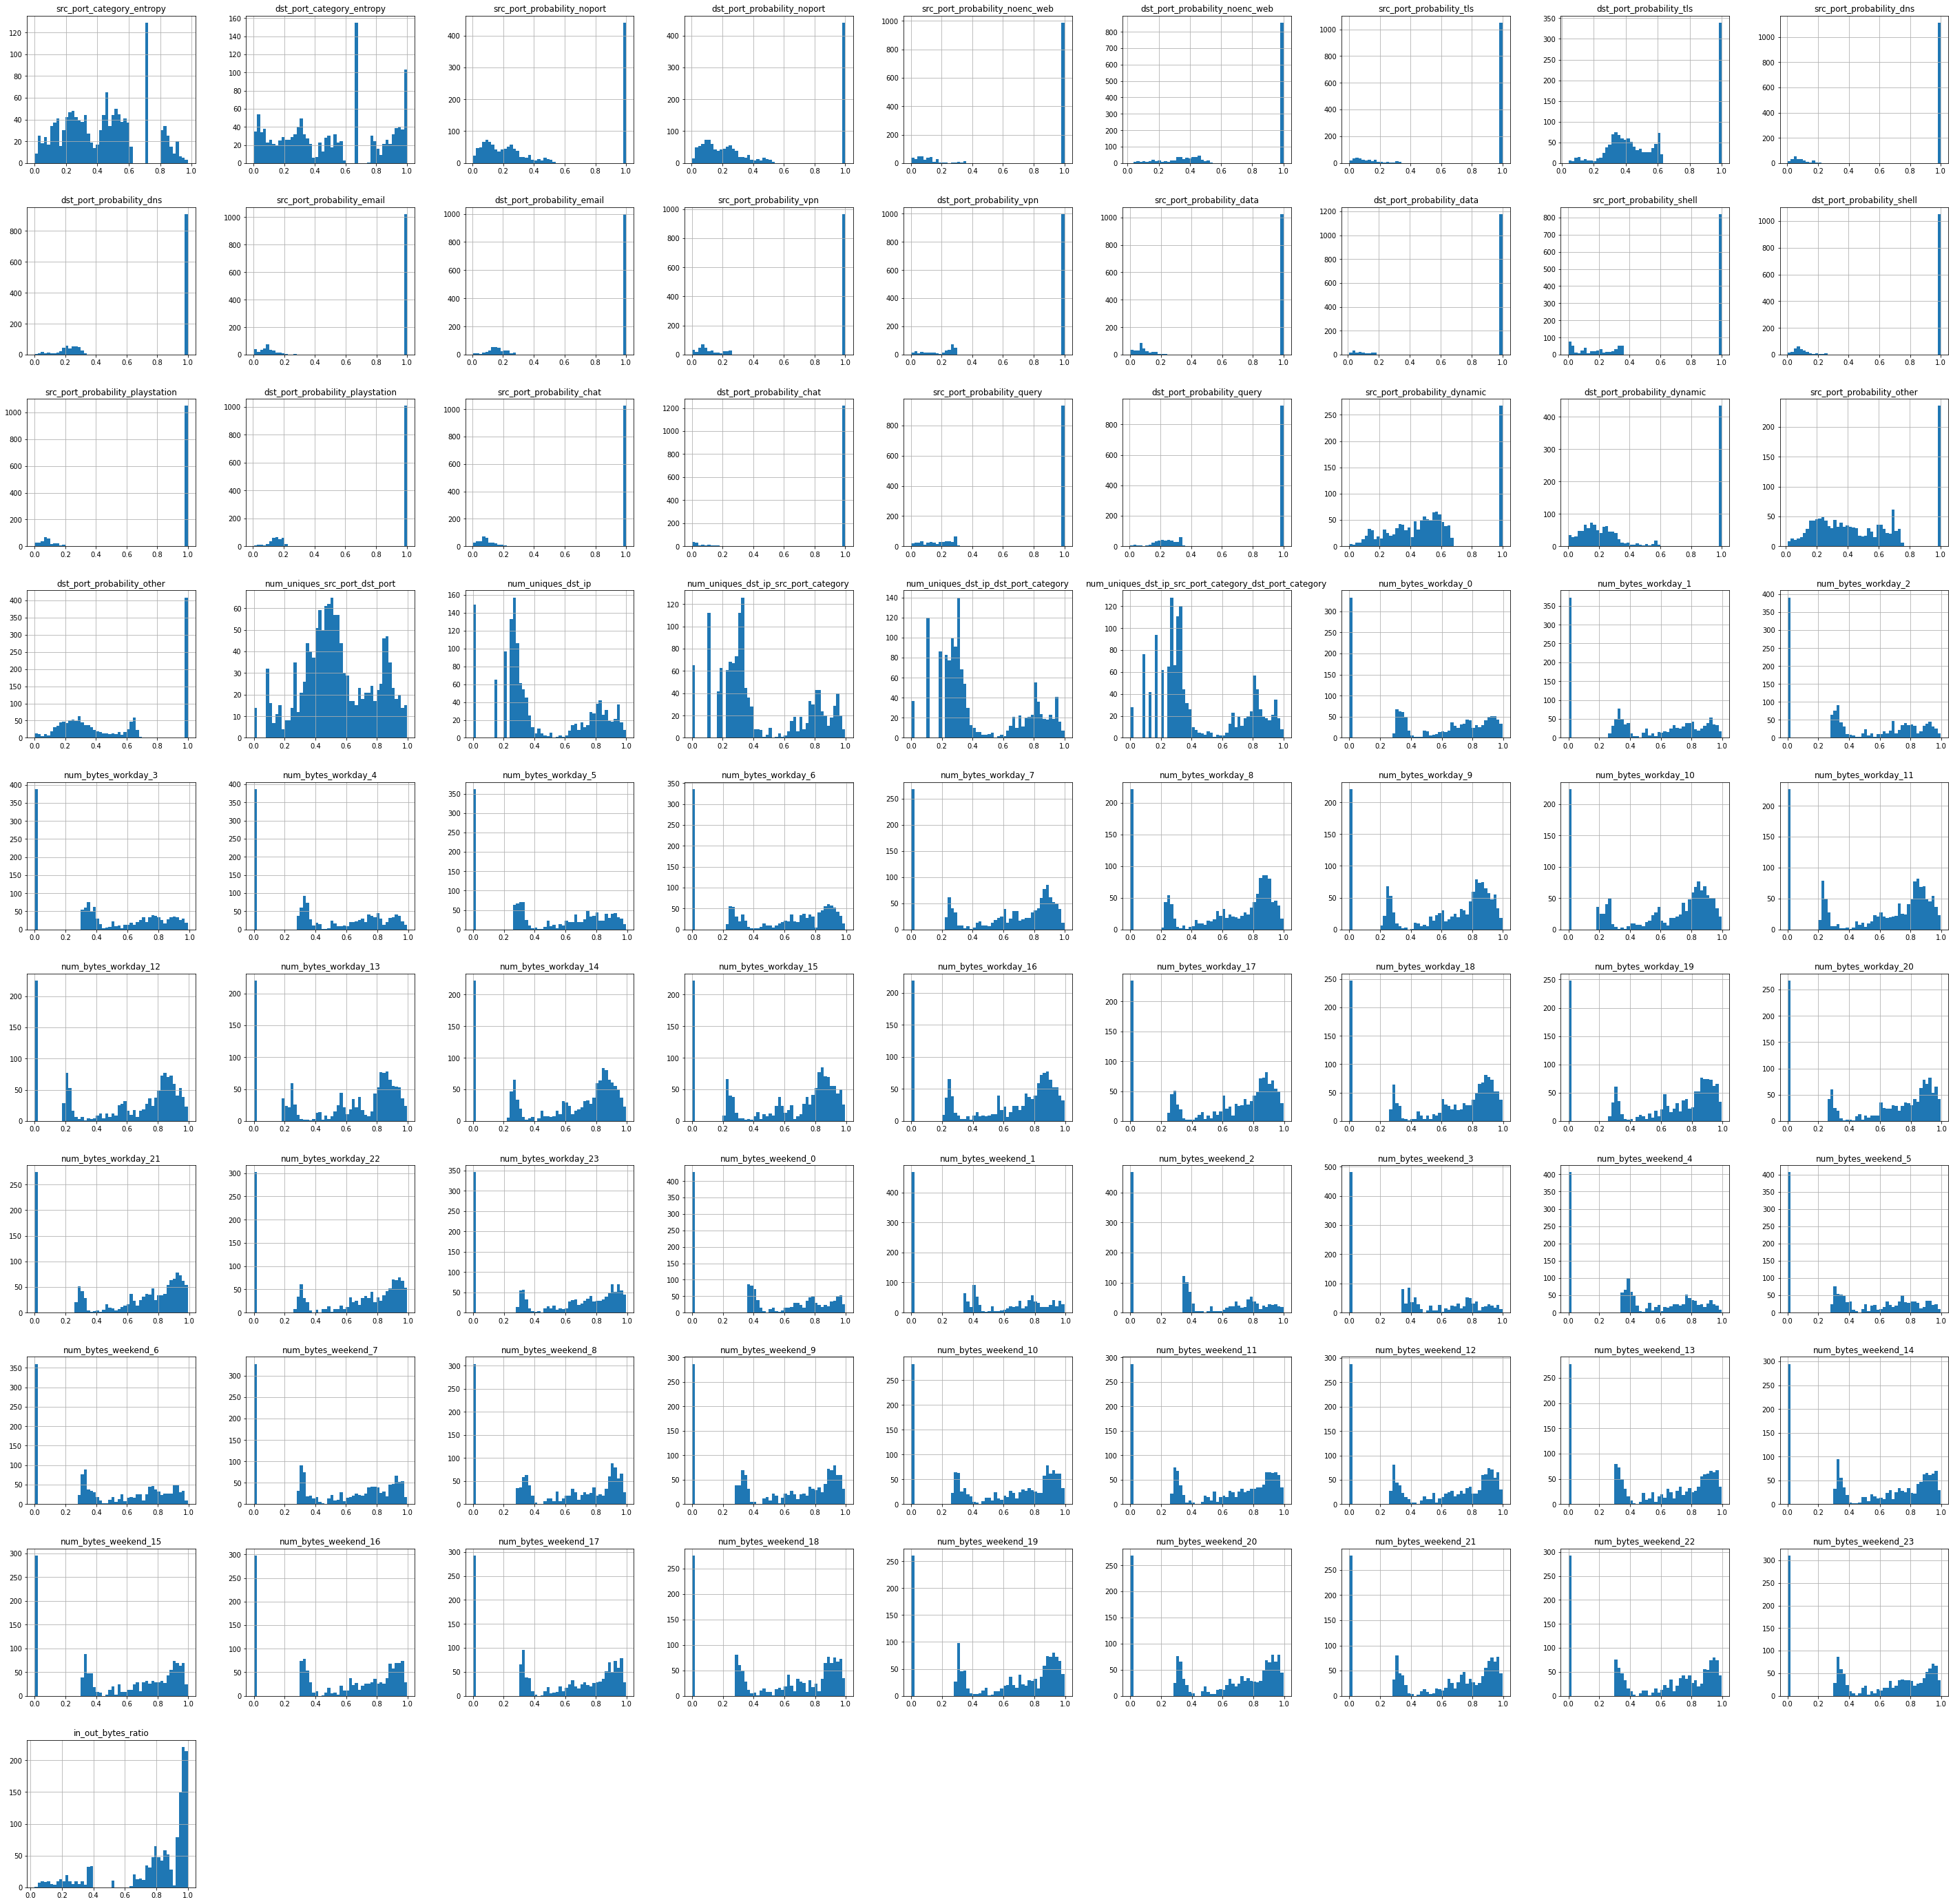

In [92]:
df_features_scaled_custom = pd.DataFrame(
    transform_pos_to_pos_and_neg(df_features_filtered[columns_to_plot].to_numpy()), columns=columns_to_plot, index=df_features_filtered.index)

scaler = sklearn_preprocessing.QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

df_features_scaled_custom = pd.DataFrame(
    scaler.fit_transform(df_features_scaled_custom.to_numpy()), columns=columns_to_plot, index=df_features_scaled_custom.index)

df_features_scaled_custom[df_features_filtered['category'] == 'SH'].hist(bins=50, figsize=(50, 50))
df_features_scaled_custom[df_features_filtered['category'] == 'NET'].hist(bins=50, figsize=(50, 50))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f431e852700>,
      dtype=object)

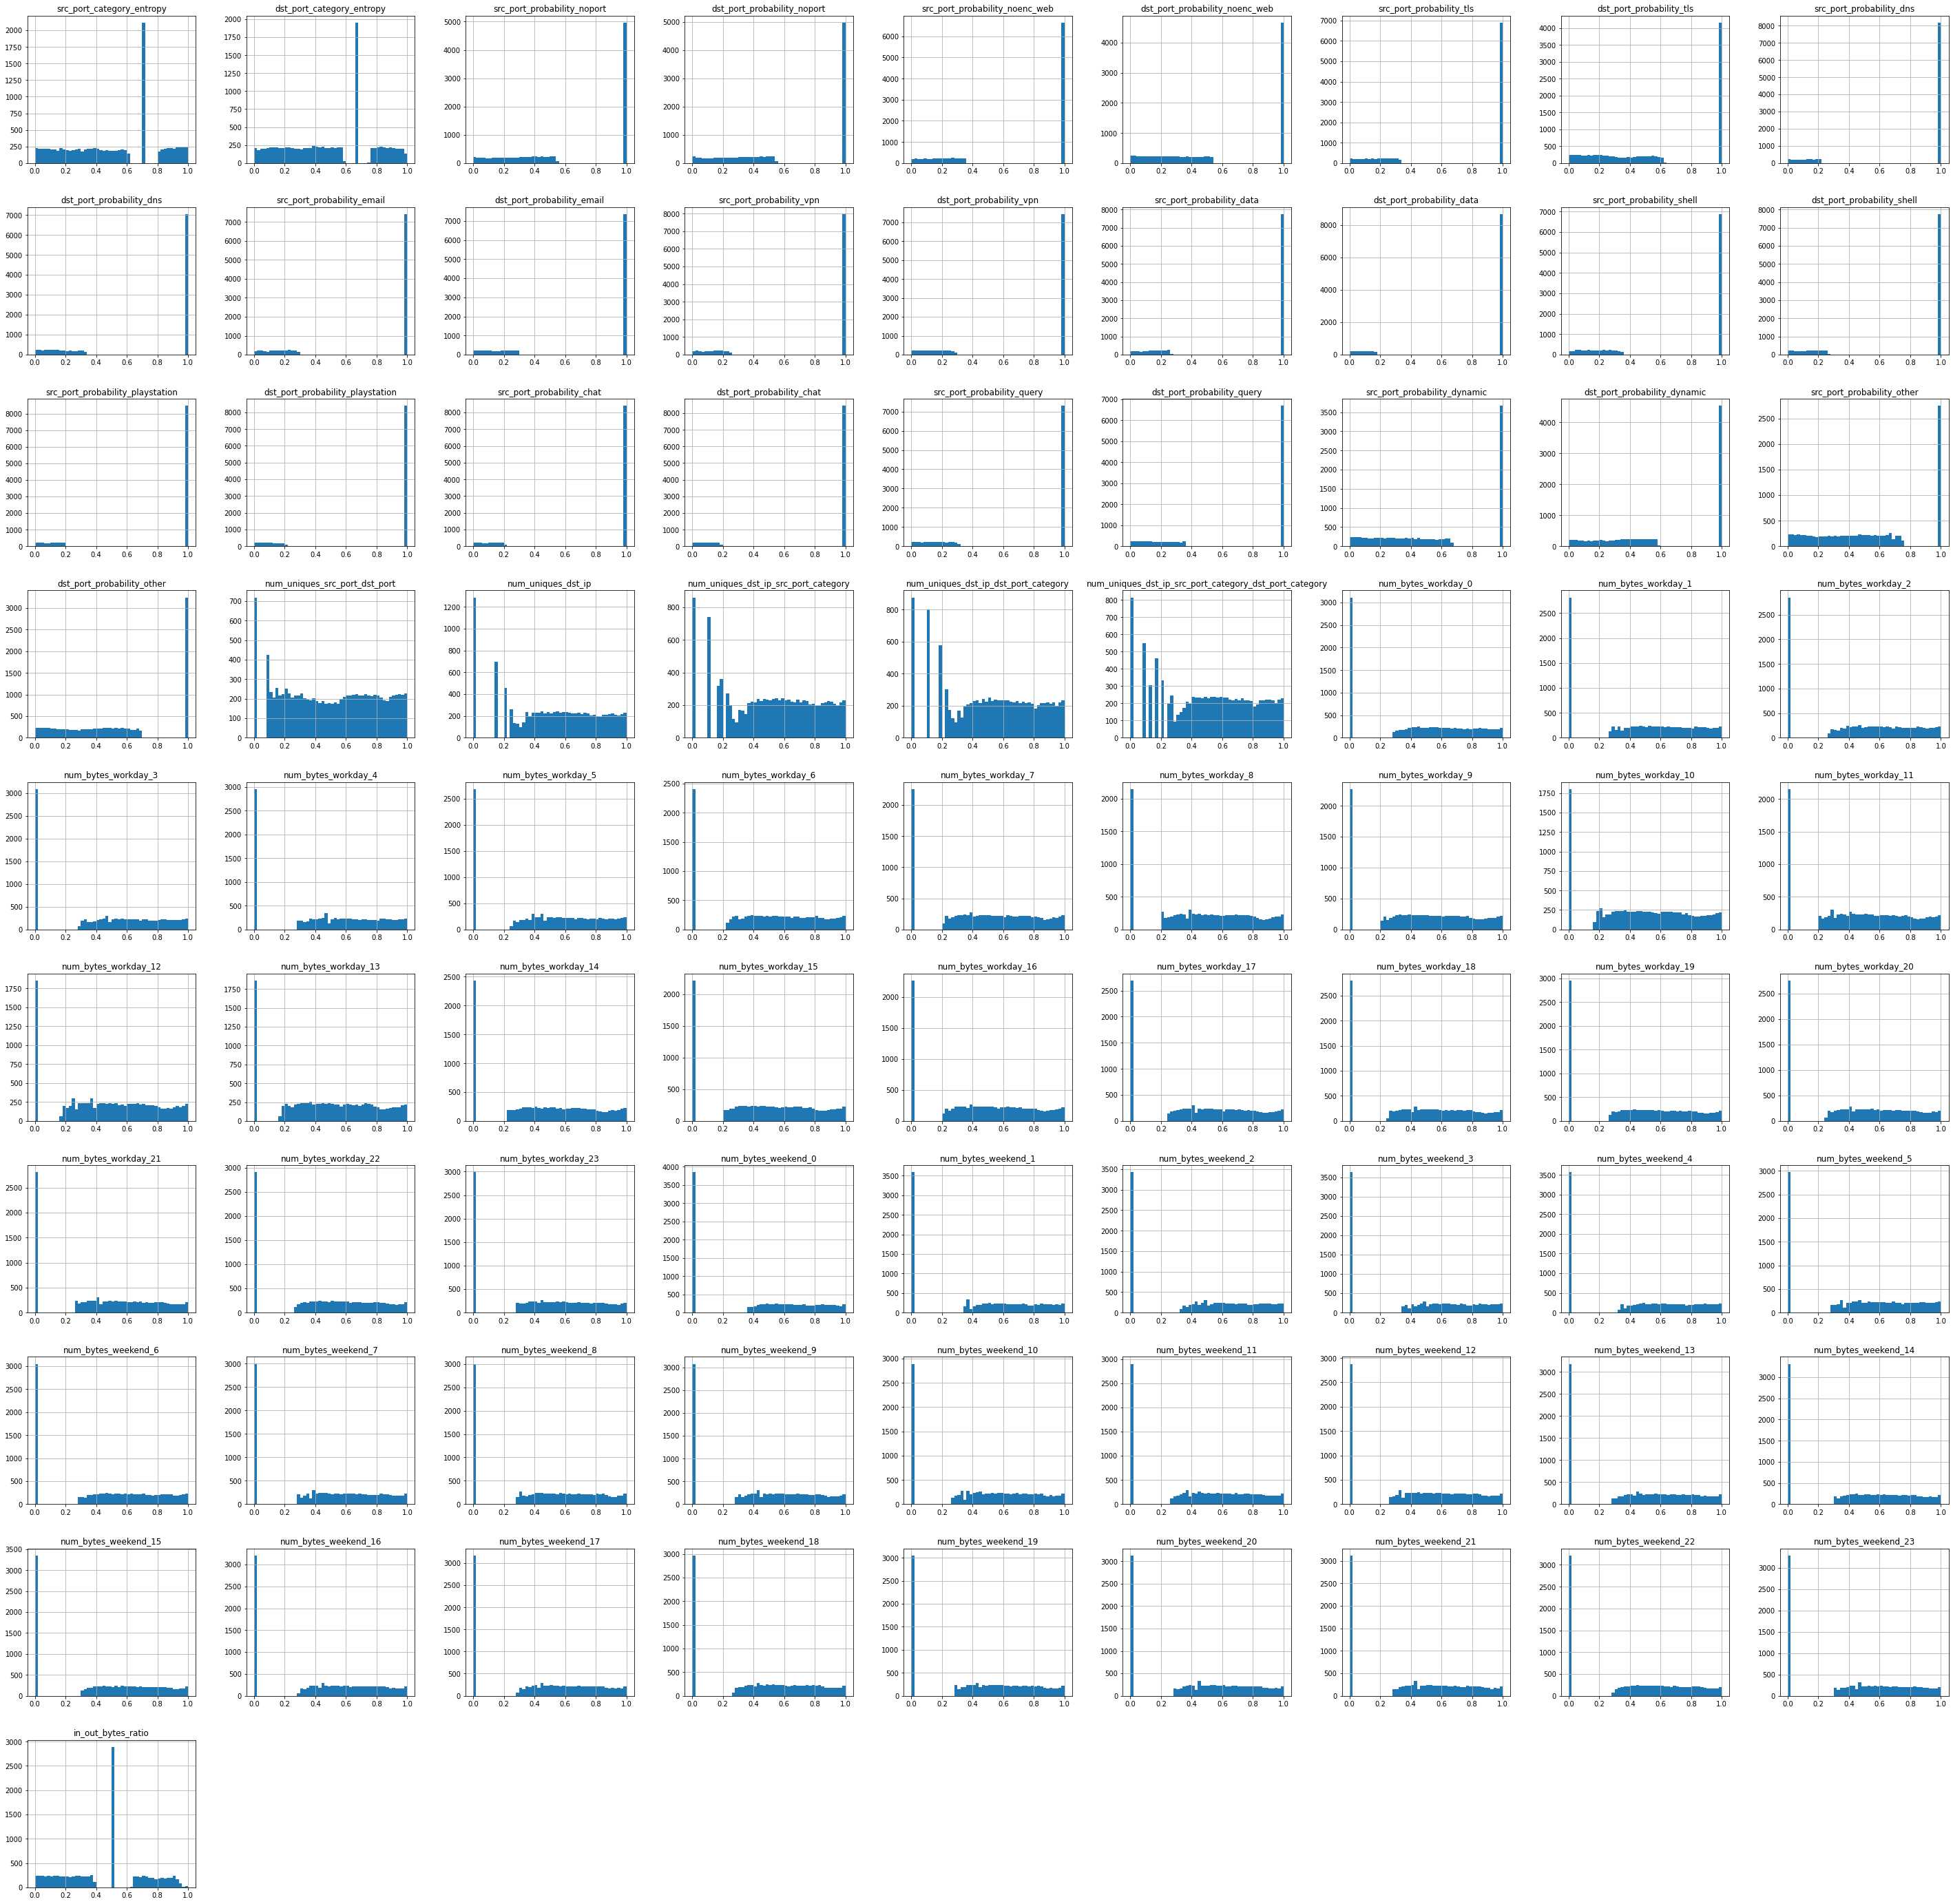

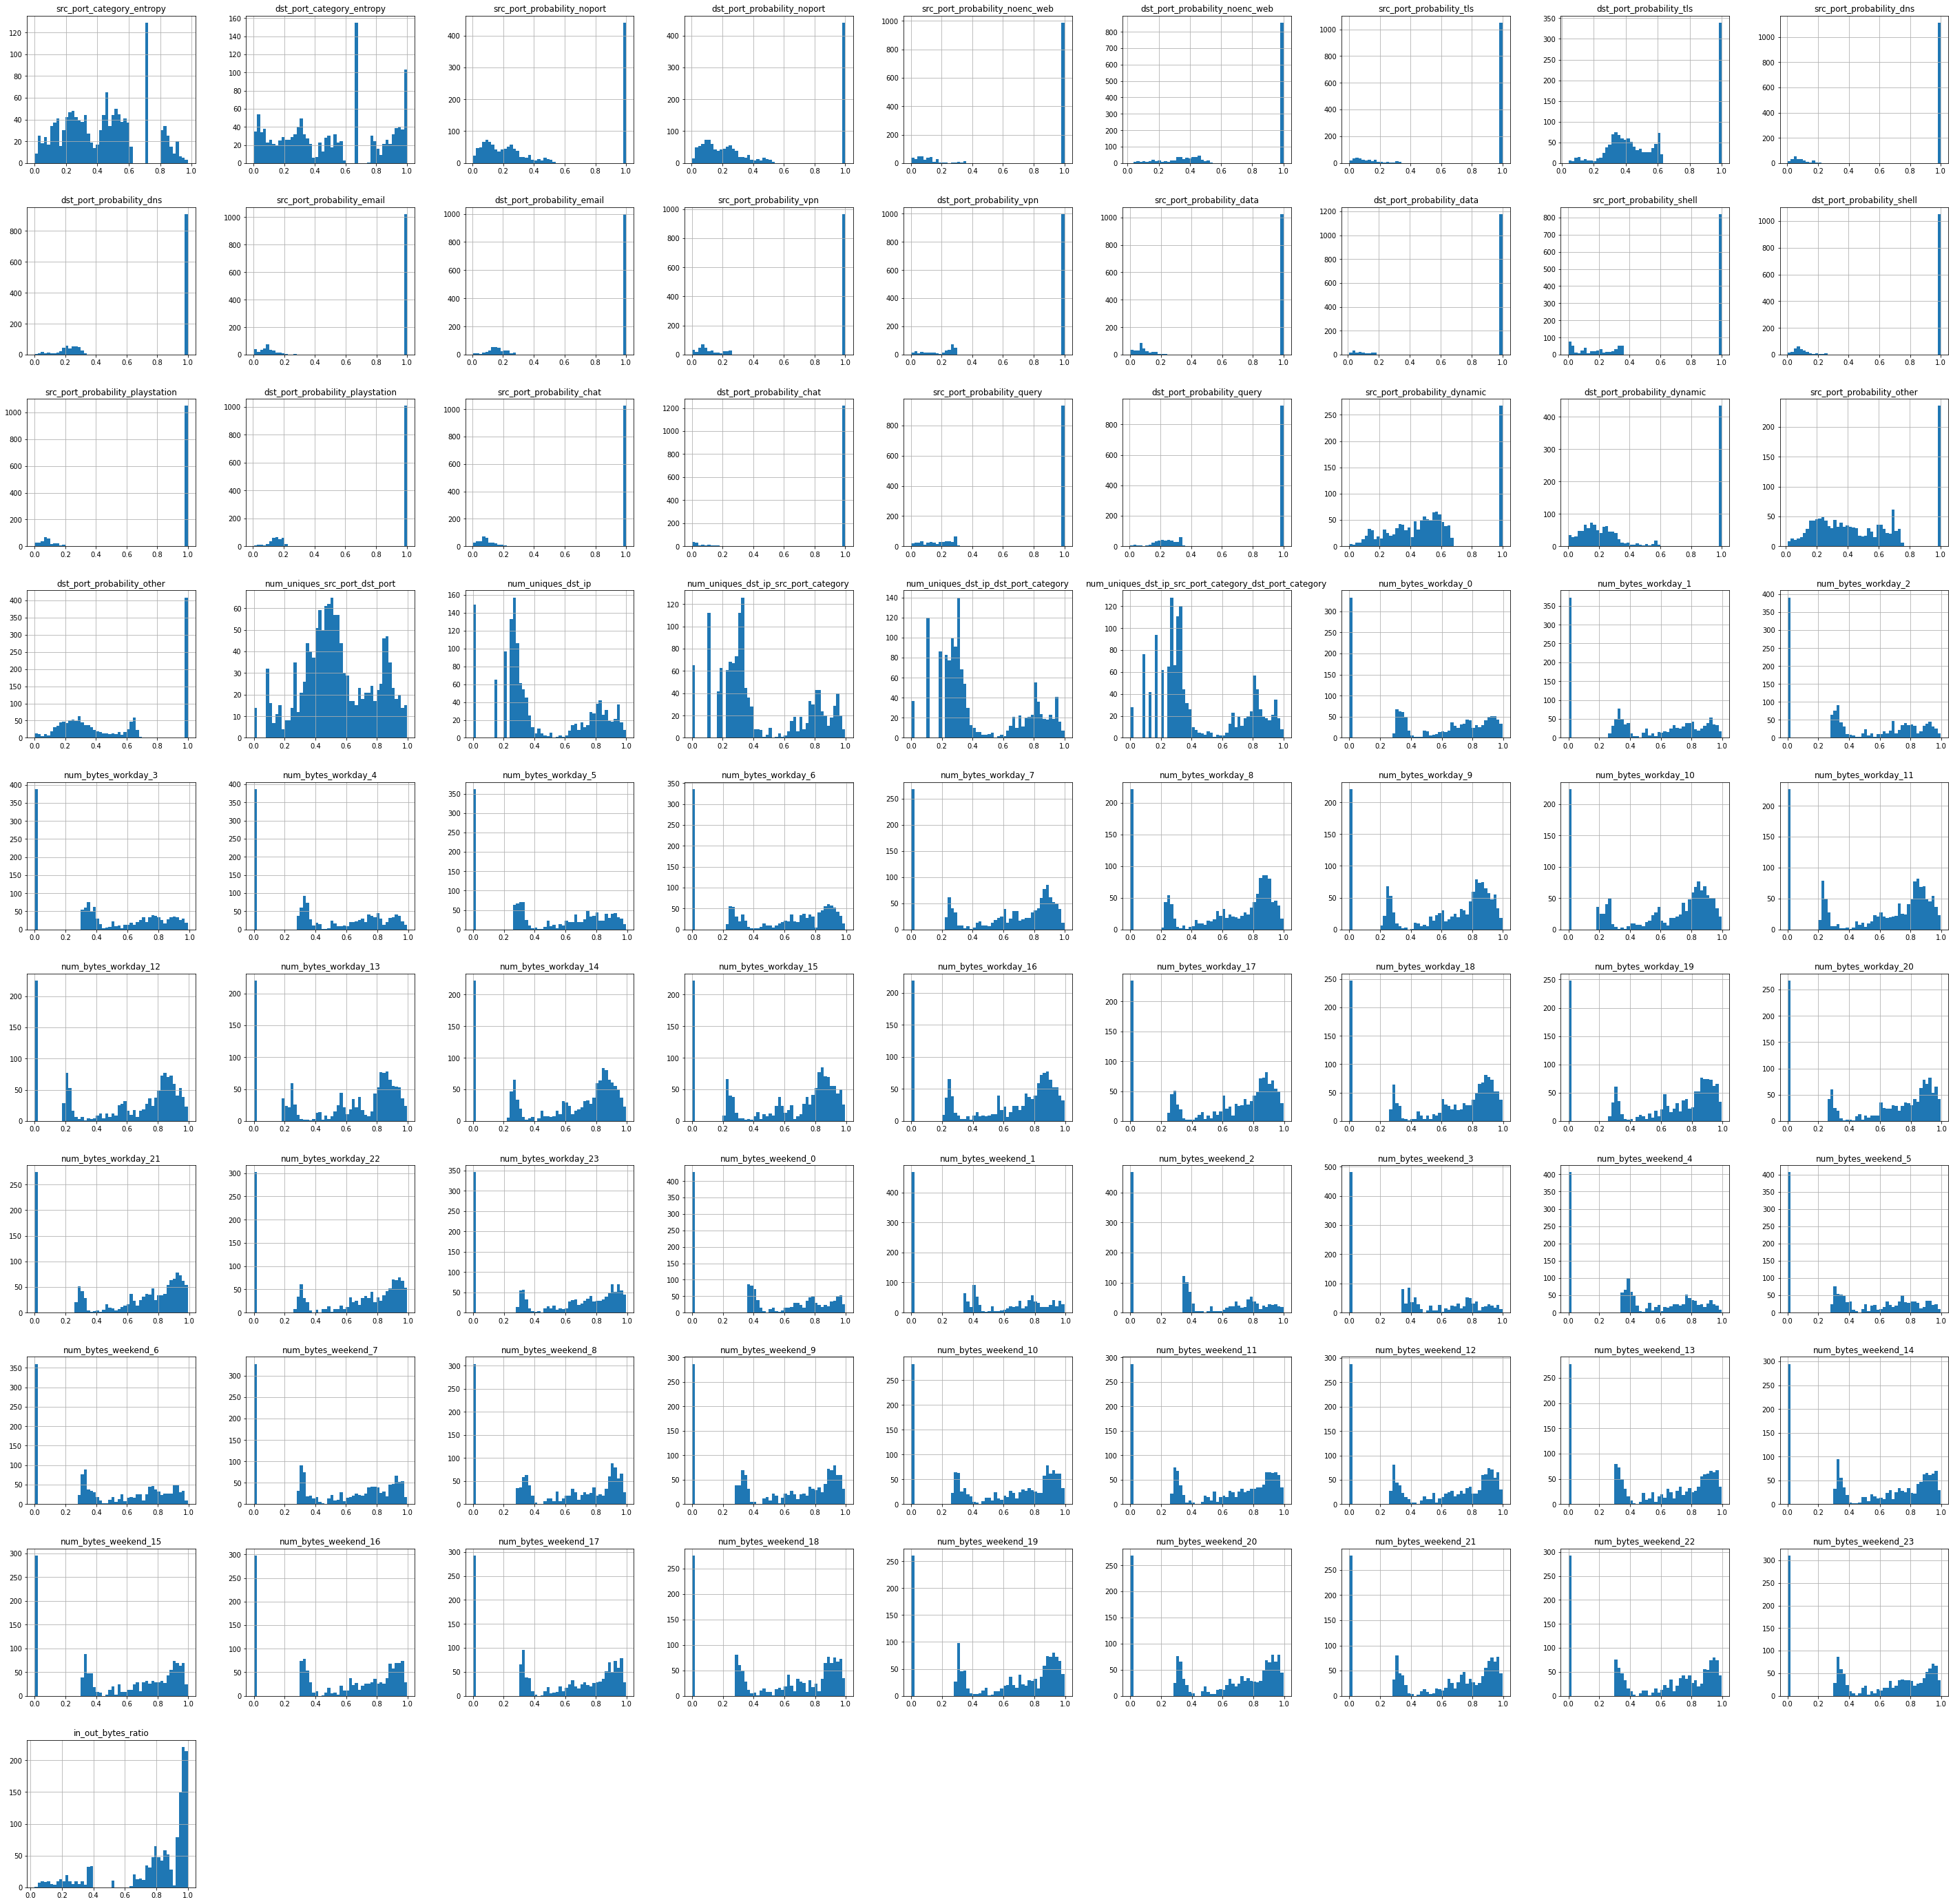

In [ ]:
df_features_scaled_custom = pd.DataFrame(
    transform_pos_to_pos_and_neg(df_features_filtered[columns_to_plot].to_numpy()), columns=columns_to_plot, index=df_features_filtered.index)

scaler = sklearn_preprocessing.QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

df_features_scaled_custom = pd.DataFrame(
    scaler.fit_transform(df_features_scaled_custom.to_numpy()), columns=columns_to_plot, index=df_features_scaled_custom.index)

df_features_scaled_custom[df_features_filtered['category'] == 'SH'].hist(bins=50, figsize=(50, 50))
df_features_scaled_custom[df_features_filtered['category'] == 'NET'].hist(bins=50, figsize=(50, 50))

The quantile transform applied on top of our custom transform shifted the prevalent zero values to the middle of the distribution for port entropies and in/out bytes.

The custom transform did not have any effect on unique counts - this is expected as there should always be at least one unique destination IP, so there are no values between 0 and 1 to be transformed to negative values and thus no changes in the distribution took place. Subtracting -1 from values > 1 (all values are > 1) did not have any effect when normalizing to the 0-1 range.